## Tool Boxes

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.cm as cm
fm._load_fontmanager()

import string
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
#Load the data
raw_df = pd.read_csv("USvideos.csv")

In [3]:
#raw_df

## Data Cleaning

#### Null is MCAR, MAR, or MNAR?

[MAR]

In [4]:
# Determine if the missing data is MCAR, MAR, or MNAR
def analyze_missing_data(df, variable):
    # Check if the missing data is MCAR
    sns.histplot(df[df.isnull().sum(axis=1) == 0][variable], kde=False, label="No Missing Values", color="#008000")
    sns.histplot(df[df.isnull().sum(axis=1) > 0][variable], kde=False, label="Missing Values", color="#FFC0CB")
    plt.legend()
    plt.title(f"Distribution of {variable} for Rows with and without Missing Values")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.ylim(0, 200)
    plt.show()

    # Check if the missing data is MAR
    sns.histplot(df[(df[variable] < df[variable].mean()) & (df.isnull().sum(axis=1) == 0)][variable], kde=False, label="No Missing Values (Below Average)", color="#008000")
    sns.histplot(df[(df[variable] < df[variable].mean()) & (df.isnull().sum(axis=1) > 0)][variable], kde=False, label="Missing Values (Below Average)", color="#FFC0CB")
    plt.legend()
    plt.title(f"Distribution of {variable} for Rows with and without Missing Values (Below Average)")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.ylim(0, 800)
    plt.show()

    sns.histplot(df[(df[variable] >= df[variable].quantile(0.5)) & (df[variable] < df[variable].quantile(0.85)) & (df.isnull().sum(axis=1) == 0)][variable], kde=False, label="No Missing Values (Top 50% - 15%)", color="#008000")
    sns.histplot(df[(df[variable] >= df[variable].quantile(0.5)) & (df[variable] < df[variable].quantile(0.85)) & (df.isnull().sum(axis=1) > 0)][variable], kde=False, label="Missing Values (Top 50% - 15%)", color="#FFC0CB")
    plt.legend()
    plt.title(f"Distribution of {variable} for Rows with and without Missing Values (Top 50% - 15%)")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.ylim(0, 800)
    plt.show()

    sns.histplot(df[(df[variable] >= df[variable].quantile(0.85)) & (df[variable] < df[variable].quantile(1)) & (df.isnull().sum(axis=1) == 0)][variable], kde=False, label="No Missing Values (Top 15%)", color="#008000")
    sns.histplot(df[(df[variable] >= df[variable].quantile(0.85)) & (df[variable] < df[variable].quantile(1)) & (df.isnull().sum(axis=1) > 0)][variable], kde=False, label="Missing Values (Top 15%)", color="#FFC0CB")
    plt.legend()
    plt.title(f"Distribution of {variable} for Rows with and without Missing Values (Top 15%)")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.ylim(0, 200)
    plt.show()

In [5]:
missing_values = raw_df.isnull().sum().sum()
print(f"Total Number of missing values: {missing_values}")

Total Number of missing values: 570


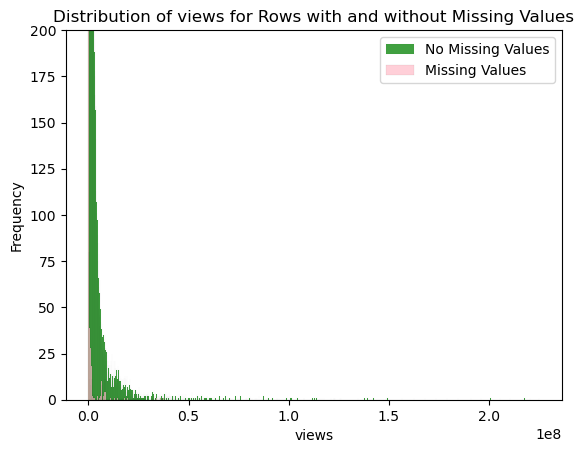

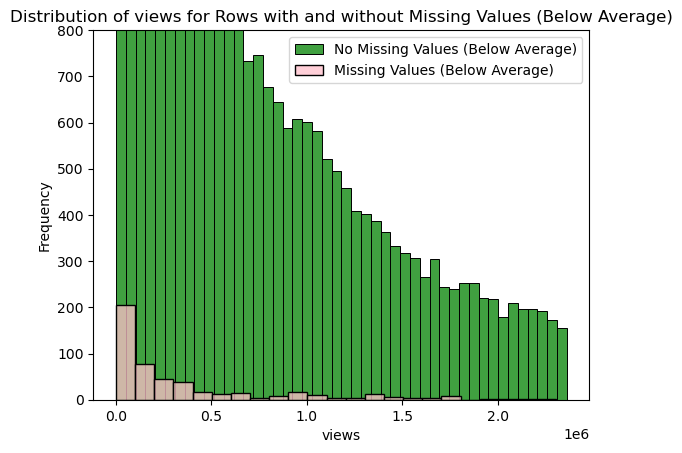

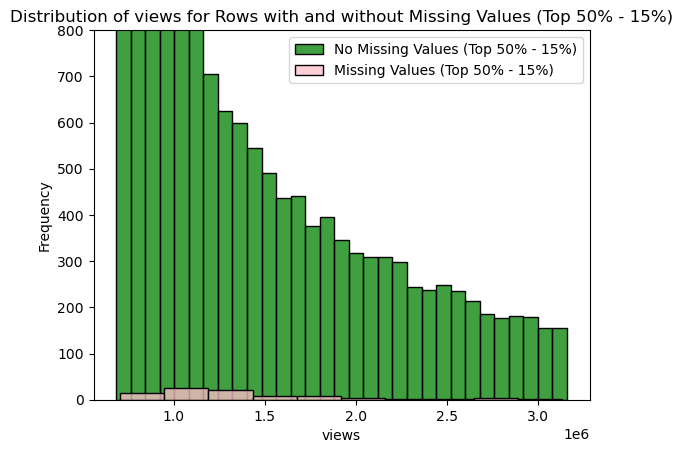

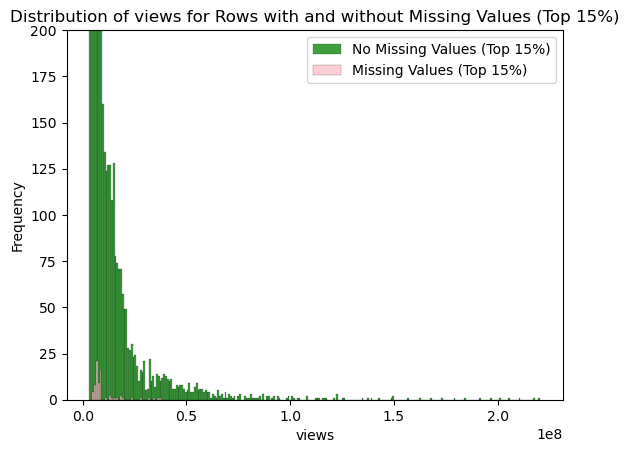

In [6]:
# Analyze the missing data on "views"
analyze_missing_data(raw_df, "views")

Null is [MAR]

#### Clean and transform data type

1. Transform data type
2. Remove stop words
3. Drop NA
4. Drop duplicates
5. Drop negatives
6. Address outliner (Winsorization)

In [7]:
raw_df.dtypes
#raw_df

video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object

In [8]:
def remove_stop_words(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
    return ' '.join(filtered_text)

In [9]:
# Only run once
def clean_and_transform_data(df):
    # 1. Change the data types of the variables
    df['video_id'] = df['video_id'].astype(str)
    df['title'] = df['title'].astype(str)
    df['channel_title'] = df['channel_title'].astype(str)
    df['category_id'] = df['category_id'].astype(int)
    df['publish_time'] = pd.to_datetime(df['publish_time'])
    df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')  # Updated line
    df['tags'] = df['tags'].astype(str)
    df['views'] = df['views'].astype(int)
    df['likes'] = df['likes'].astype(int)
    df['dislikes'] = df['dislikes'].astype(int)
    df['comment_count'] = df['comment_count'].astype(int)
    df['thumbnail_link'] = df['thumbnail_link'].astype(str)
    df['comments_disabled'] = df['comments_disabled'].astype(bool)
    df['ratings_disabled'] = df['ratings_disabled'].astype(bool)
    df['video_error_or_removed'] = df['video_error_or_removed'].astype(bool)
    df['description'] = df['description'].astype(str)

    # 2. Removing stop words
    df['title'] = df['title'].apply(remove_stop_words)
    df['tags'] = df['tags'].apply(remove_stop_words)
    df['description'] = df['description'].apply(remove_stop_words)

    # 3. Drop missing values
    df = df.dropna()

    # 4. Drop duplicates
    duplicates = df.duplicated().sum()
    print(f"Number of duplicates: {duplicates}")
    df = df.drop_duplicates()

    # 5. Drop negative values
    int_vars = df.select_dtypes(include=['int']).columns
    for var in int_vars:
        negative_values = df[df[var] < 0].count()[var]
        print(f"Number of negative values in {var}: {negative_values}")
        df = df[df[var] >= 0]

    # 6. Use Winsorization to deal with outliers in the views variable
    if not df.empty:
        views_before = df['views'].copy()
        df['views'] = winsorize(df['views'], limits=[0.1, 0.1])

        # Visualize the distribution of views [before and after]
        sns.set_style('darkgrid')

        sns.histplot(views_before, kde=False, bins=80, color='#FFC0CB', label='Before Winsorization')
        sns.histplot(df['views'], kde=False, bins=60, color='#008000', label='After Winsorization')

        plt.title("Distribution of Views before and after Winsorization")
        plt.xlabel("Views")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()
    else:
        print("Dataframe is empty. Skipping Winsorization and visualization.")

    return df

Number of duplicates: 48
Number of negative values in category_id: 0
Number of negative values in views: 0
Number of negative values in likes: 0
Number of negative values in dislikes: 0
Number of negative values in comment_count: 0


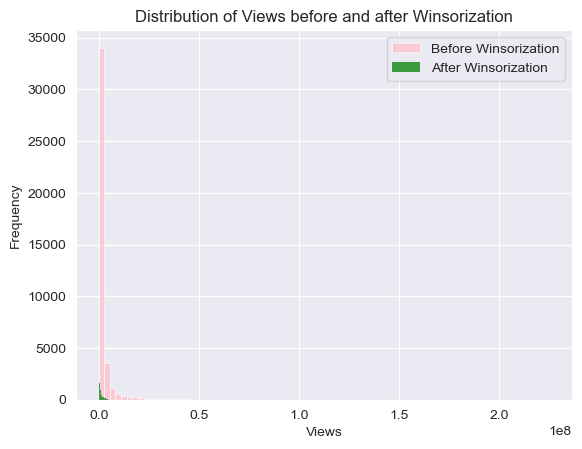

In [10]:
df = raw_df
df = clean_and_transform_data(df)

In [11]:
#df

#### New Variables

- Category Name
- like_percentage
- like-dislike

In [12]:
def add_category_names(df):
    df['category_name'] = np.nan
    df.loc[(df["category_id"] == 1),"category"] = "Film & Animation"
    df.loc[(df["category_id"] == 2),"category"] = "Autos & Vehicles"
    df.loc[(df["category_id"] == 10),"category"] = "Music"
    df.loc[(df["category_id"] == 15),"category"] = "Pets & Animals"
    df.loc[(df["category_id"] == 17),"category"] = "Sports"
    df.loc[(df["category_id"] == 18),"category"] = "Short Movies"
    df.loc[(df["category_id"] == 19),"category"] = 'Travel and Events'
    df.loc[(df["category_id"] == 20),"category"] = 'Gaming'
    df.loc[(df["category_id"] == 21),"category"] = "Videoblogging"
    df.loc[(df["category_id"] == 22),"category"] = "People & Blogs"
    df.loc[(df["category_id"] == 23),"category"] = "Comedy"
    df.loc[(df["category_id"] == 24),"category"] = "Entertainment"
    df.loc[(df["category_id"] == 25),"category"] = "News & Politics"
    df.loc[(df["category_id"] == 26),"category"] = "Howto & Style"
    df.loc[(df["category_id"] == 27),"category"] = "Education"
    df.loc[(df["category_id"] == 28),"category"] = "Science & Technology"
    df.loc[(df["category_id"] == 29),"category"] = "Nonprofits & Activism"
    df.loc[(df["category_id"] == 30),"category"] = "Movies"
    df.loc[(df["category_id"] == 31),"category"] = "Anime/Animation"
    df.loc[(df["category_id"] == 32),"category"] = "Action/Adventure"
    df.loc[(df["category_id"] == 33),"category"] = "Classics"
    df.loc[(df["category_id"] == 34),"category"] ="Comedy"
    df.loc[(df["category_id"] == 35),"category"] ="Documentary"
    df.loc[(df["category_id"] == 36),"category"] ="Drama"
    df.loc[(df["category_id"] == 37),"category"] ="Family"
    df.loc[(df["category_id"] == 38),"category"] ="Foreign"
    df.loc[(df["category_id"] == 39),"category"] ="Horror"
    df.loc[(df["category_id"] == 40),"category"] ="Sci-Fi/Fantasy"
    df.loc[(df["category_id"] == 41),"category"] ="Thriller"
    df.loc[(df["category_id"] == 42),"category"] ="Shorts"
    df.loc[(df["category_id"] == 43),"category"] ="Shows"
    df.loc[(df["category_id"] == 44),"category"] ="Trailers"


    return df

In [13]:
df = add_category_names(df)
#df

In [14]:
def calculate_metrics(df):
    # Calculate the percentage of views that are likes
    df['like_percentage'] = df['likes'] / df['views'] * 100

    # Calculate the like-dislike ratio
    df['like_dislike_ratio'] = df['likes'] / df['dislikes']

    return df

In [15]:
df = calculate_metrics(df)
#df

In [16]:
# Rank the top categories based on the counts of each category

# Group by 'category' column and get the count of occurrences
category_counts = df.groupby('category')['category'].size()

# Sort the counts in descending order
category_counts = category_counts.sort_values(ascending=False)

print(category_counts)

category
Entertainment            9944
Music                    6467
Howto & Style            4142
Comedy                   3453
People & Blogs           3208
News & Politics          2485
Science & Technology     2397
Film & Animation         2343
Sports                   2172
Education                1655
Pets & Animals            920
Gaming                    816
Travel and Events         401
Autos & Vehicles          384
Nonprofits & Activism      57
Shows                      57
Name: category, dtype: int64


In [17]:
def summary_stats(df):
    print("Summary Statistics:")
    print(df.describe())

# Apply the summary statistics function to the data
summary_stats(df)

Summary Statistics:
        category_id         views         likes      dislikes  comment_count  \
count  40901.000000  4.090100e+04  4.090100e+04  4.090100e+04   4.090100e+04   
mean      19.970588  1.310251e+06  7.427173e+04  3.711722e+03   8.448567e+03   
std        7.569362  1.452274e+06  2.289999e+05  2.904624e+04   3.745139e+04   
min        1.000000  7.055100e+04  0.000000e+00  0.000000e+00   0.000000e+00   
25%       17.000000  2.419720e+05  5.416000e+03  2.020000e+02   6.130000e+02   
50%       24.000000  6.810640e+05  1.806900e+04  6.300000e+02   1.855000e+03   
75%       25.000000  1.821926e+06  5.533800e+04  1.936000e+03   5.752000e+03   
max       43.000000  4.601037e+06  5.613827e+06  1.674420e+06   1.361580e+06   

       category_name  like_percentage  like_dislike_ratio  
count            0.0     40901.000000        4.073100e+04  
mean             NaN         3.948606                 inf  
std              NaN         5.155571                 NaN  
min              Na

## Analysis

### Bigram Analysis

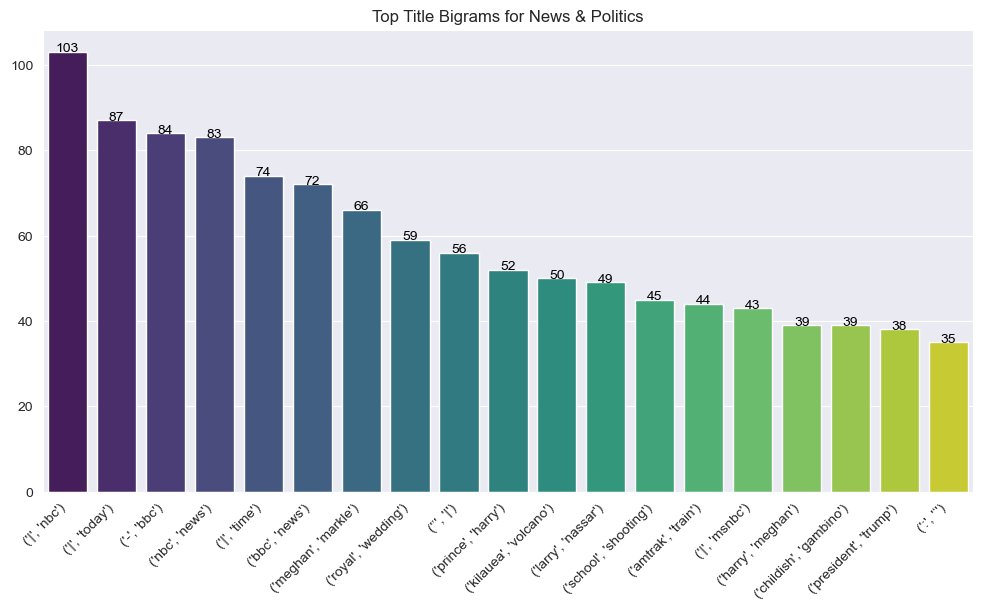

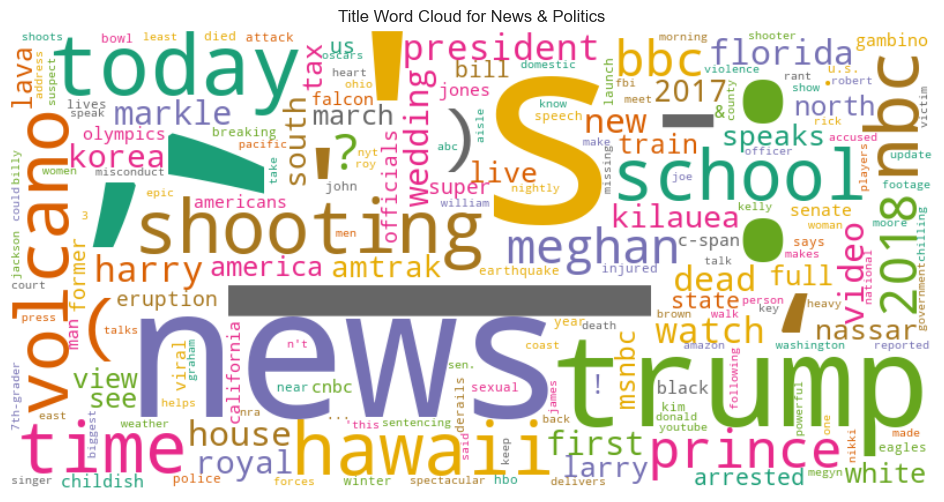

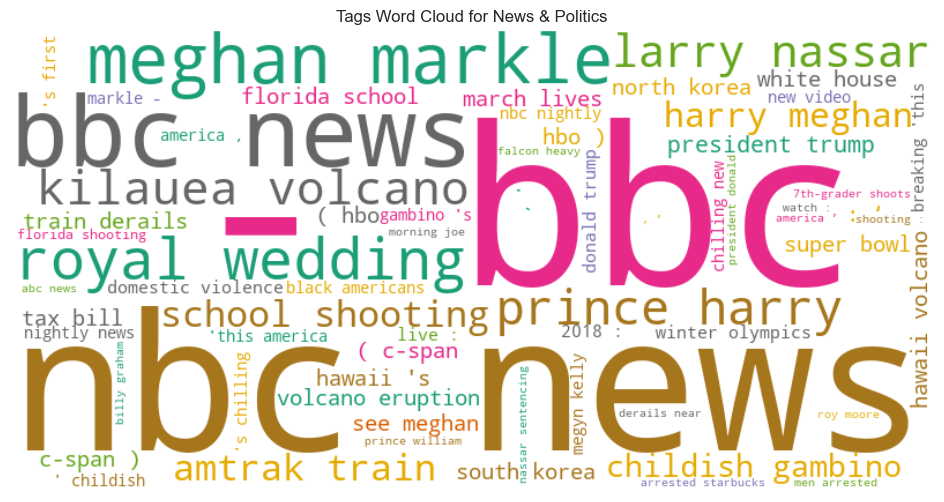

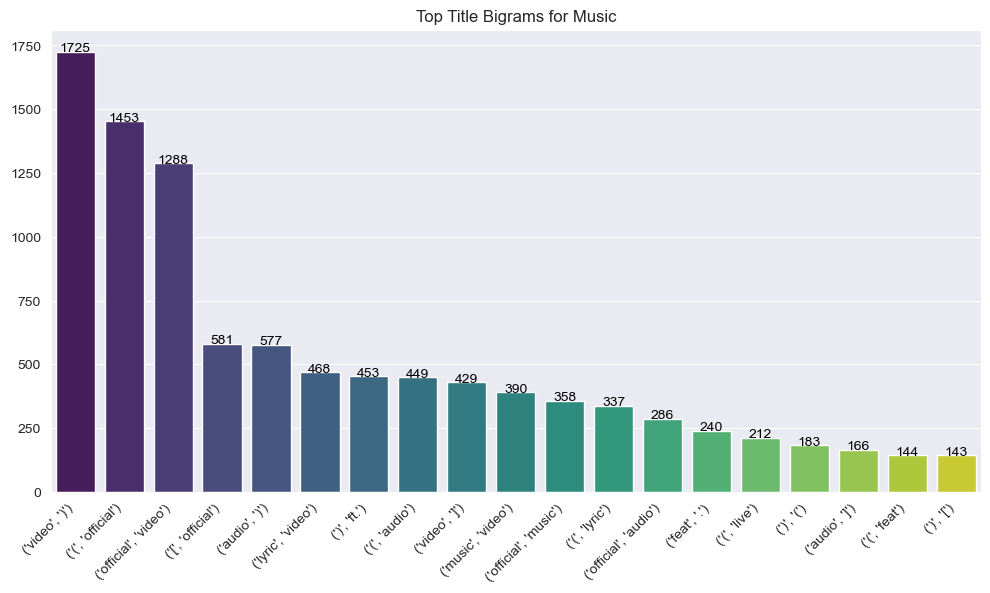

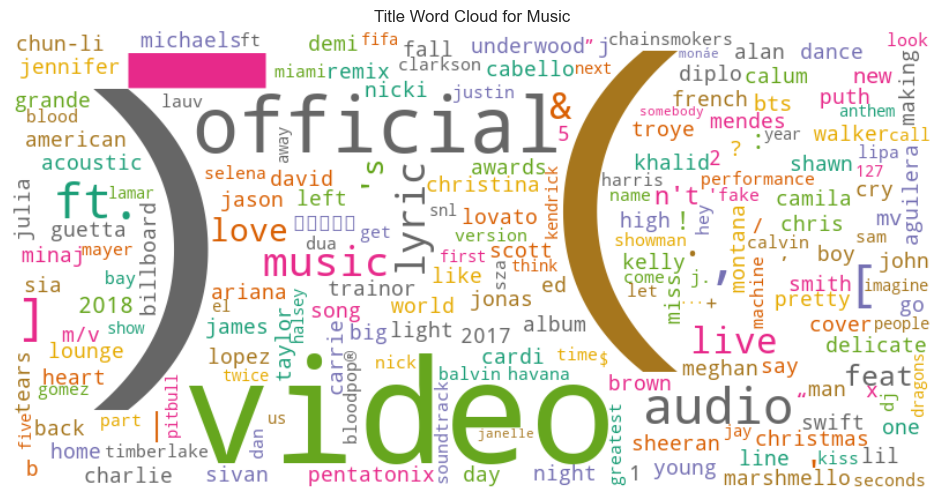

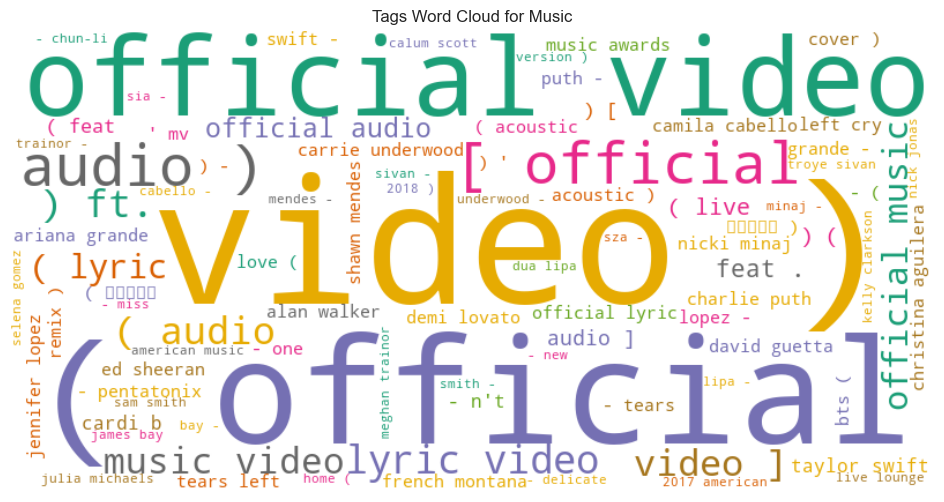

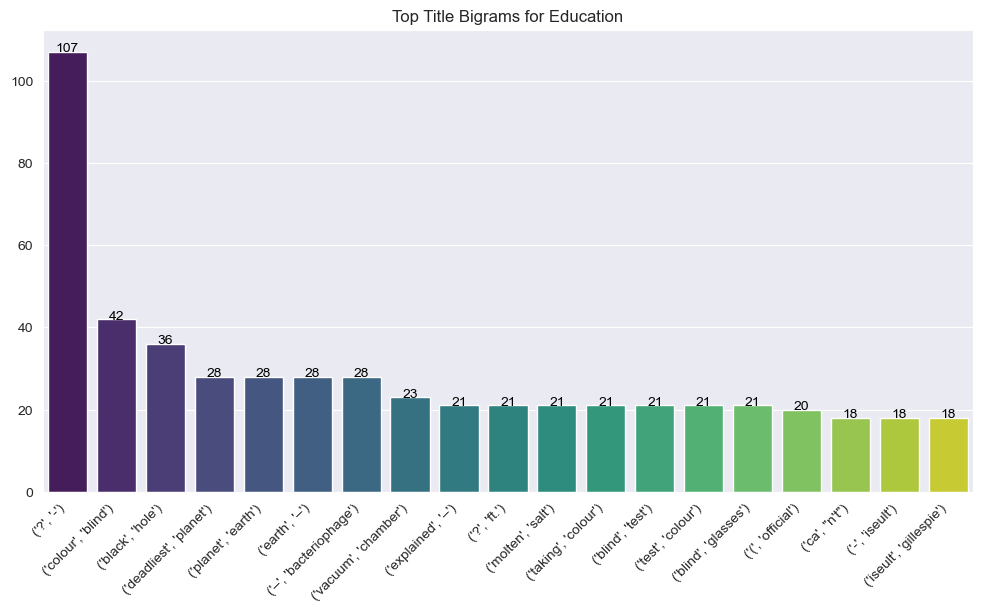

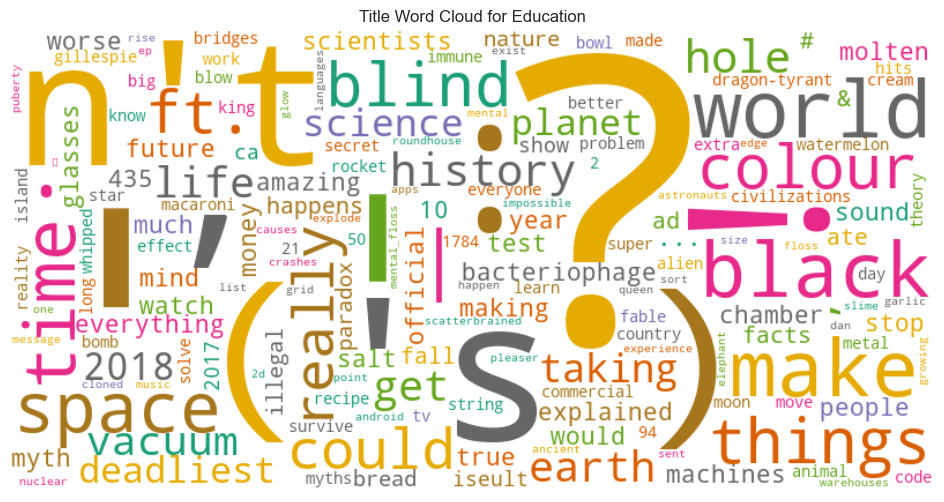

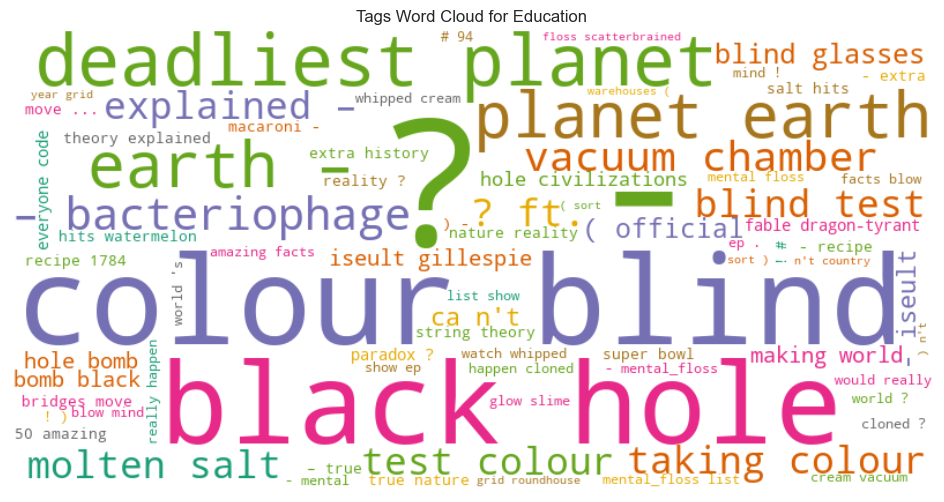

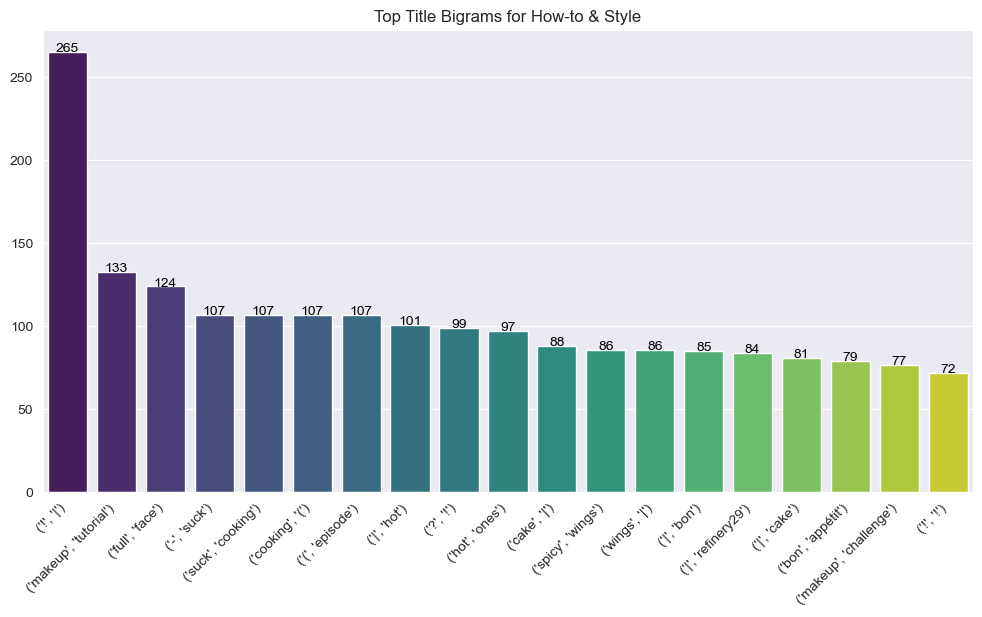

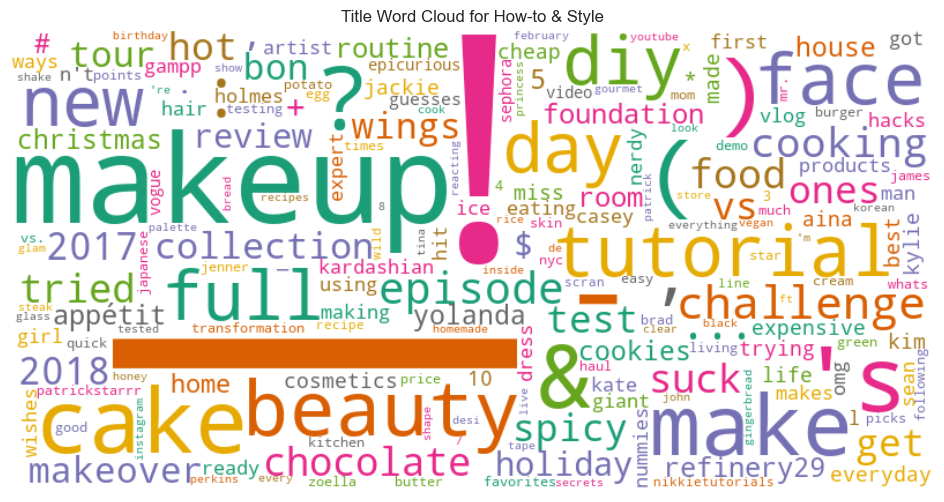

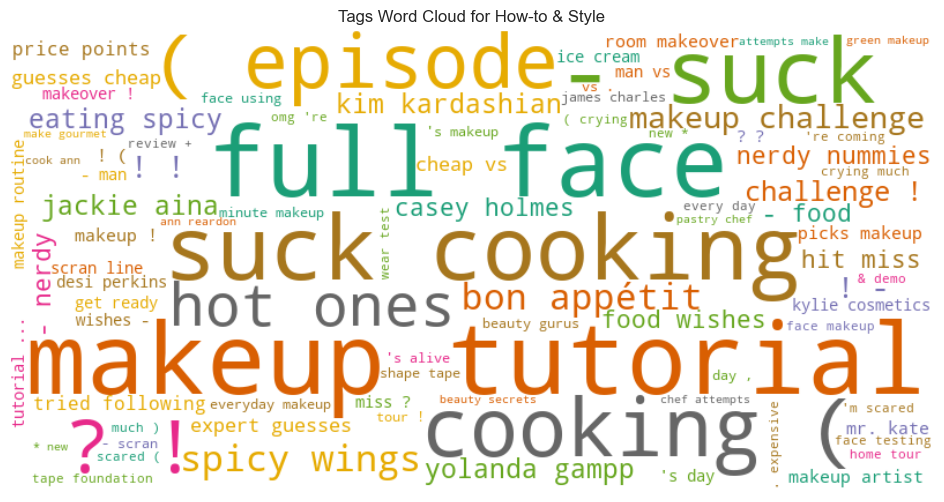

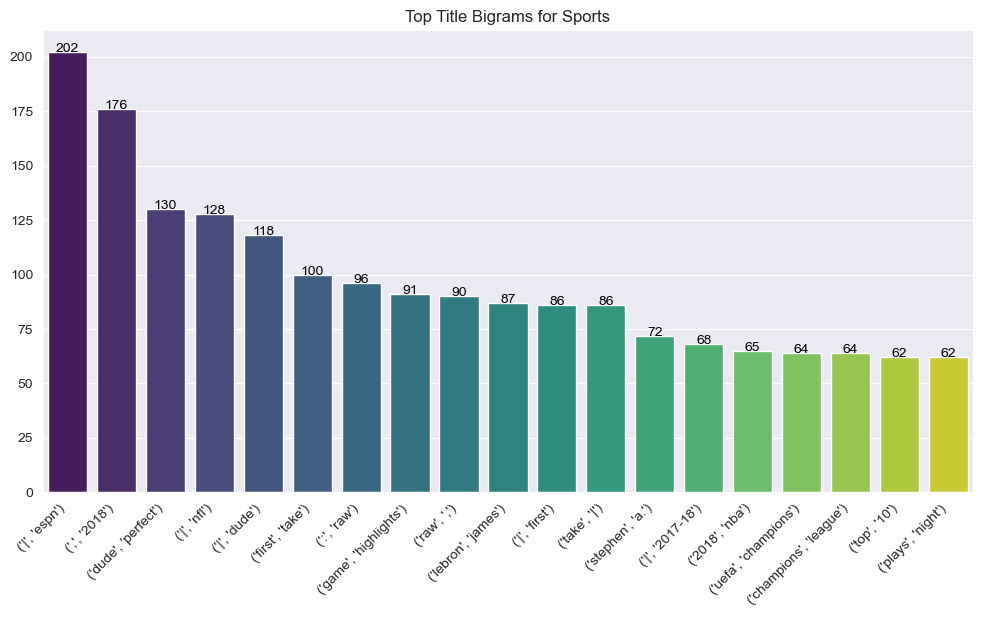

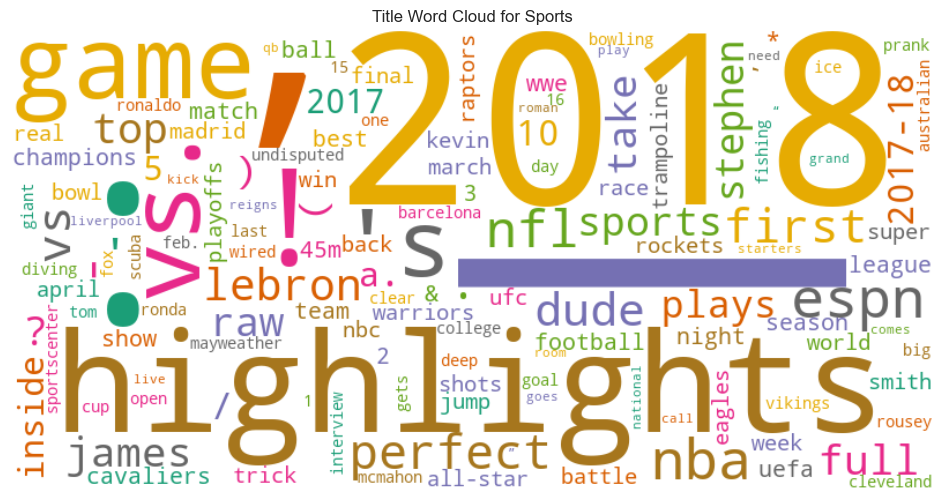

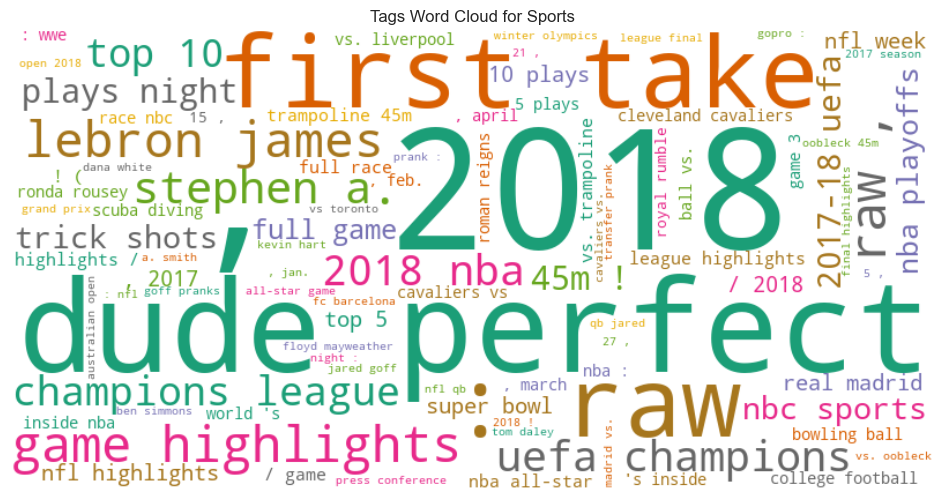

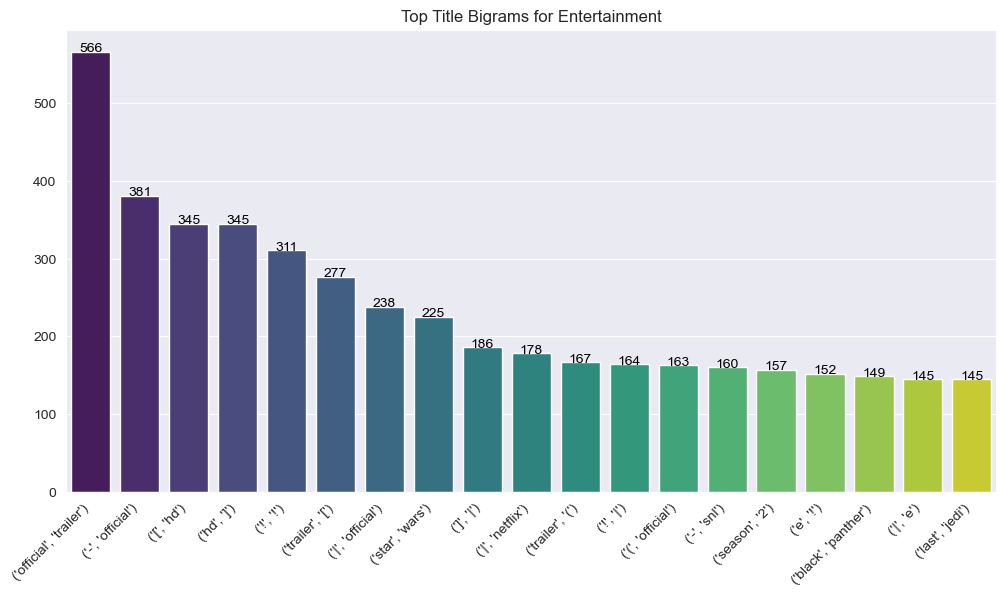

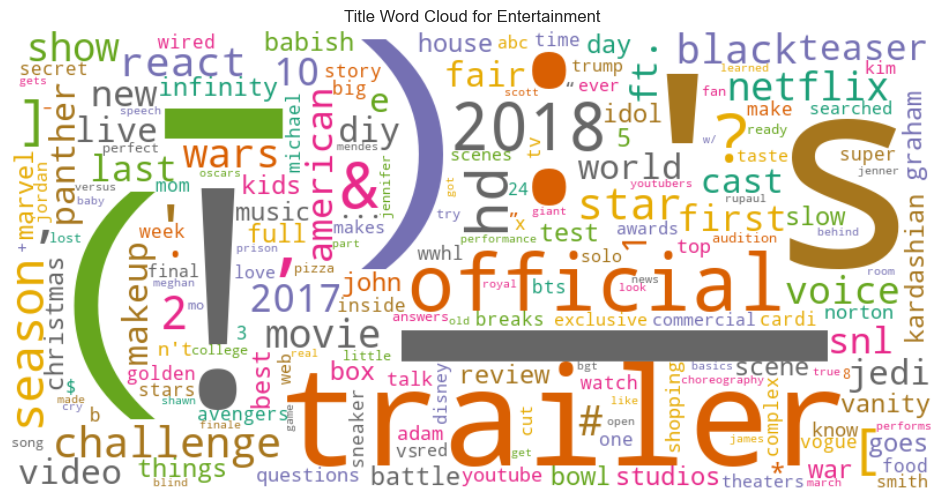

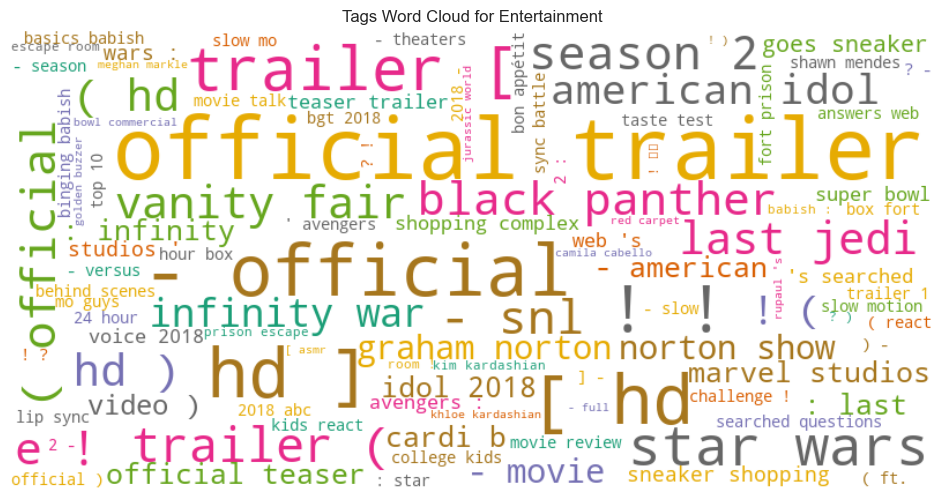

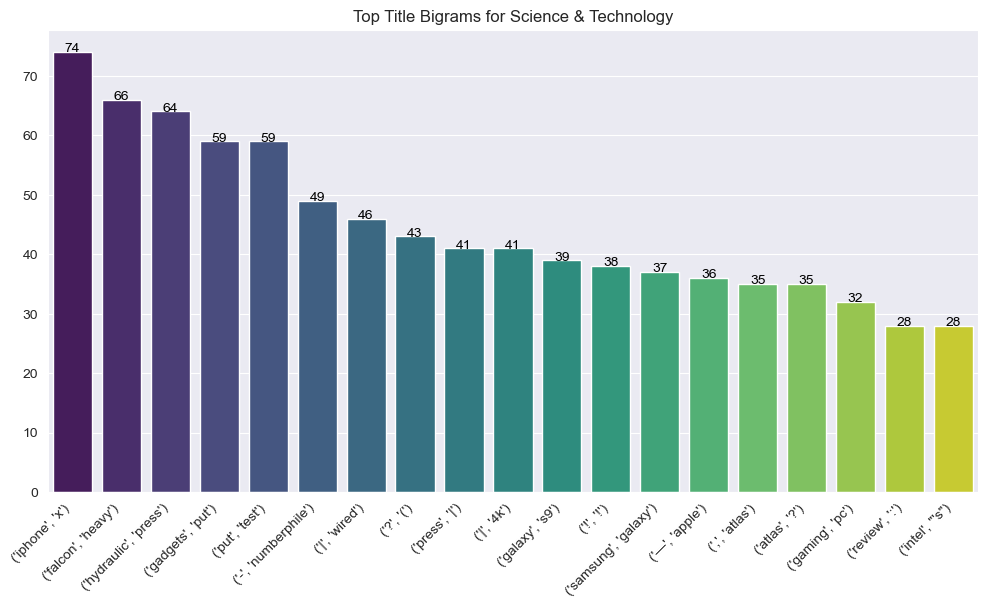

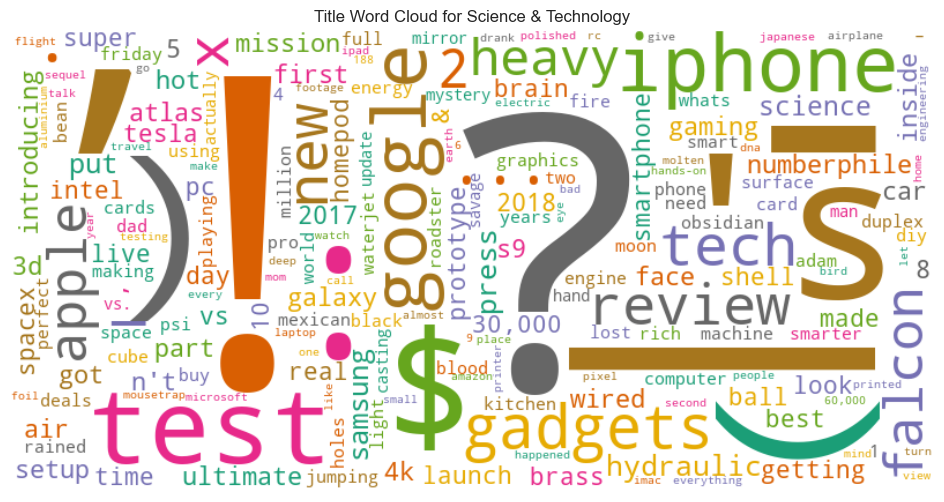

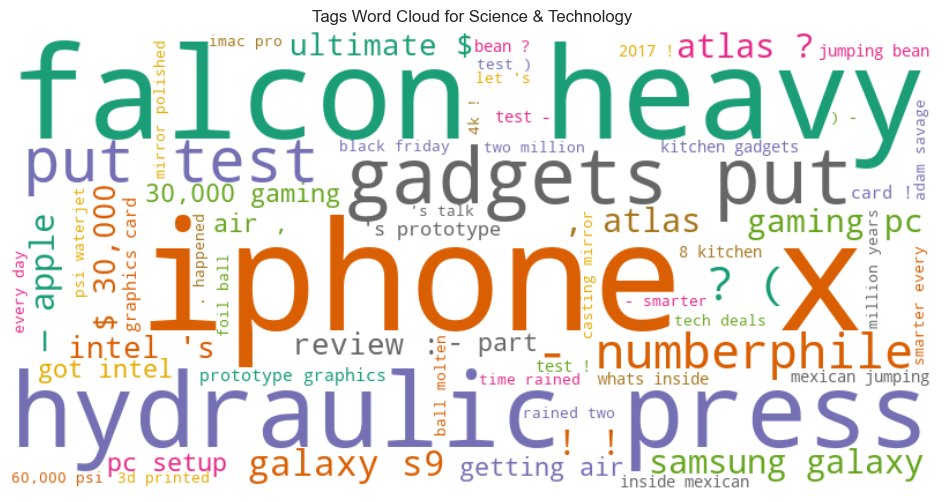

In [18]:
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud

# List of categories and their corresponding category_id values
categories = [
    ('News & Politics', 25),
    ('Music', 10),
    ('Education', 27),
    ('How-to & Style', 26),
    ('Sports', 17),
    ('Entertainment', 24),
    ('Science & Technology', 28)
    # ('Shows',)
]

for category_name, category_id_filter in categories:
    filtered_videos = df[df['category_id'] == category_id_filter]

    # Tokenize and extract bigrams
    bigrams_list = []
    words_list = []
    tag_bigrams_list = []

    for title in filtered_videos['title']:
        tokens = title.lower().split()
        bigrams = list(ngrams(tokens, 2))
        bigrams_list.extend(bigrams)
        words_list.extend(tokens)

        # Tokenize and extract bigrams for tags
        tags = title.lower().split('|')
        tag_tokens = [tag.split() for tag in tags]
        tag_bigrams = [list(ngrams(tag_token, 2)) for tag_token in tag_tokens if len(tag_token) > 1]
        tag_bigrams_list.extend([bigram for tag_bigram in tag_bigrams for bigram in tag_bigram])

    # Count the bigrams and words
    bigram_counts = Counter(bigrams_list)
    word_counts = Counter(words_list)
    tag_bigram_counts = Counter(tag_bigrams_list)

    # Create a dataframe from the bigram counts
    bigram_df = pd.DataFrame.from_records(bigram_counts.most_common(), columns=['bigram', 'count'])

    # Plot the top 19 bigrams
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='bigram', y='count', data=bigram_df.head(19), palette='viridis')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(f"Top Title Bigrams for {category_name}")

    for index, row in bigram_df.head(19).iterrows():
        ax.text(index, row['count'], row['count'], color='black', ha='center')

    plt.show()

    # Generate a word cloud for title words
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2', min_font_size=10).generate_from_frequencies(word_counts)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Title Word Cloud for {category_name}")
    plt.show()

    tag_bigram_counts_str = {f'{bigram[0]} {bigram[1]}': count for bigram, count in tag_bigram_counts.items()}

    # Generate a word cloud for tag bigrams
    tag_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Dark2', min_font_size=10).generate_from_frequencies(tag_bigram_counts_str)
    plt.figure(figsize=(12, 6))
    plt.title(f"Tags Word Cloud for {category_name}")
    plt.imshow(tag_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

### Title Length Analysis

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/1643135436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))


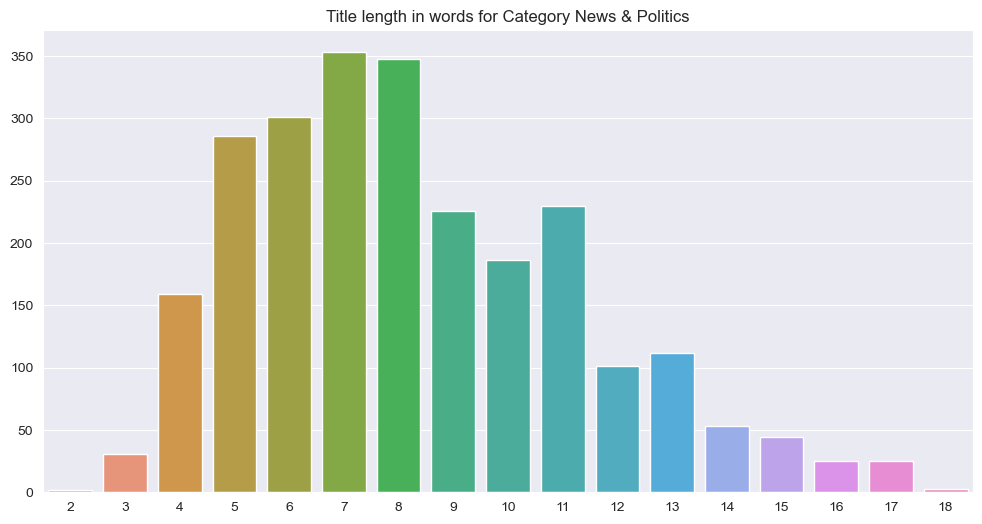

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/1643135436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))


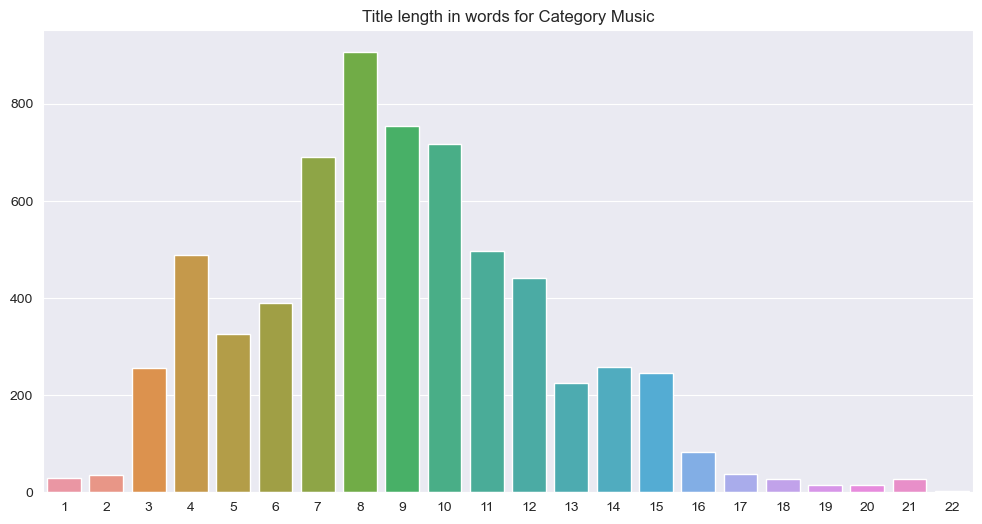

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/1643135436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))


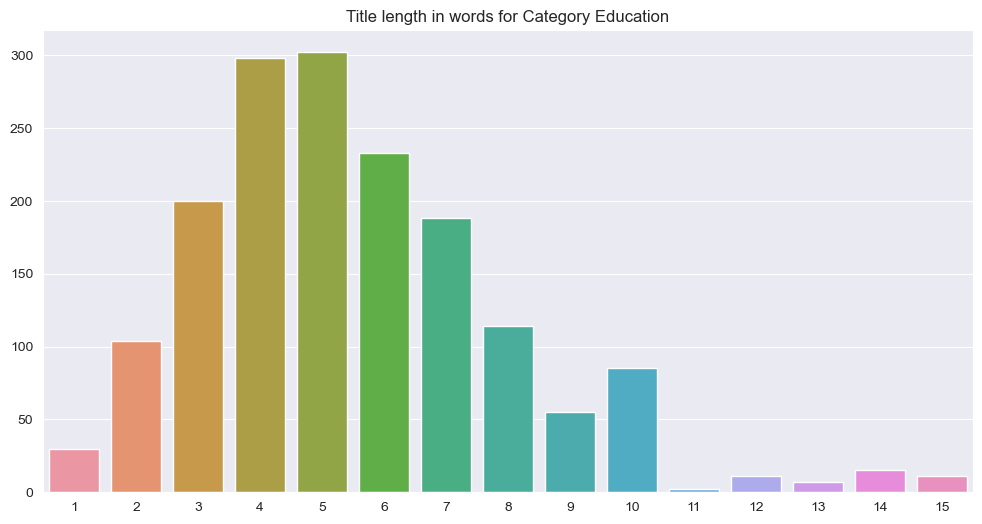

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/1643135436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))


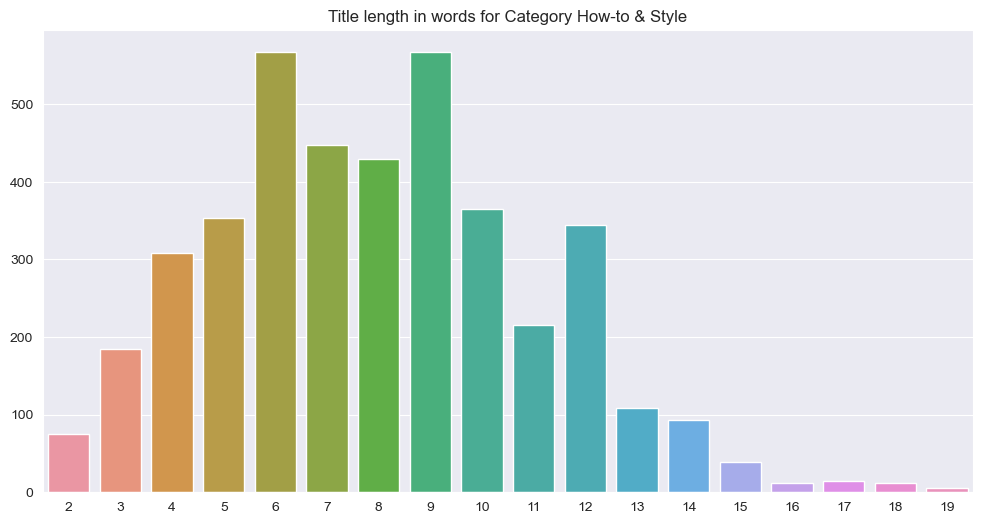

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/1643135436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))


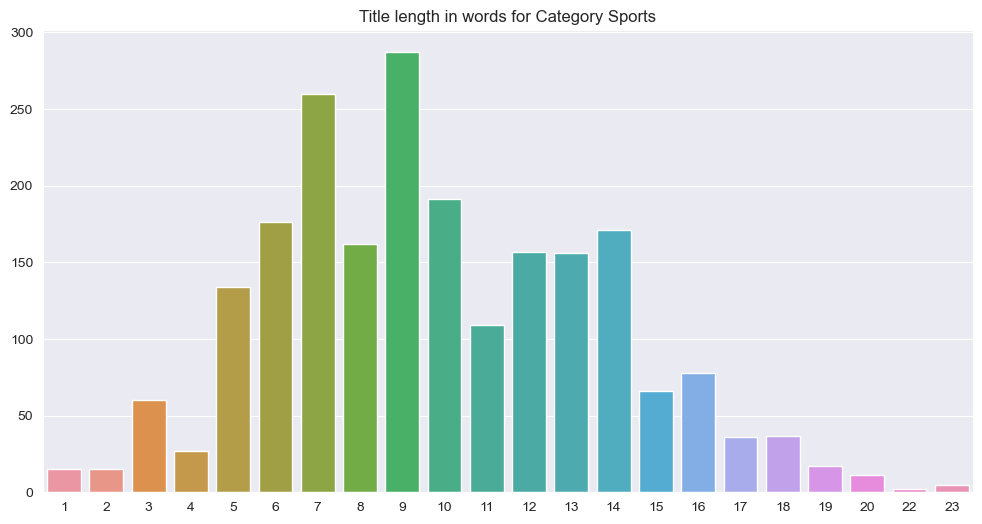

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/1643135436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))


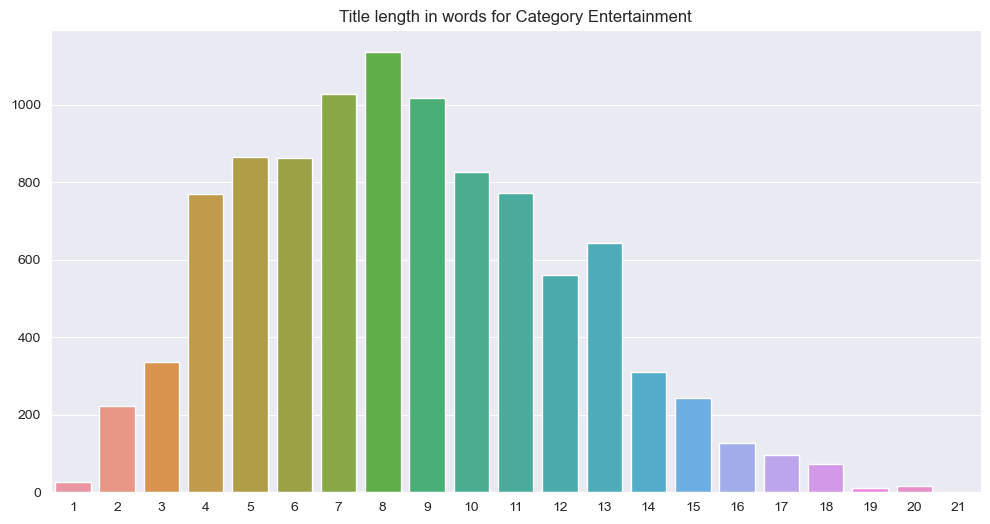

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/1643135436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))


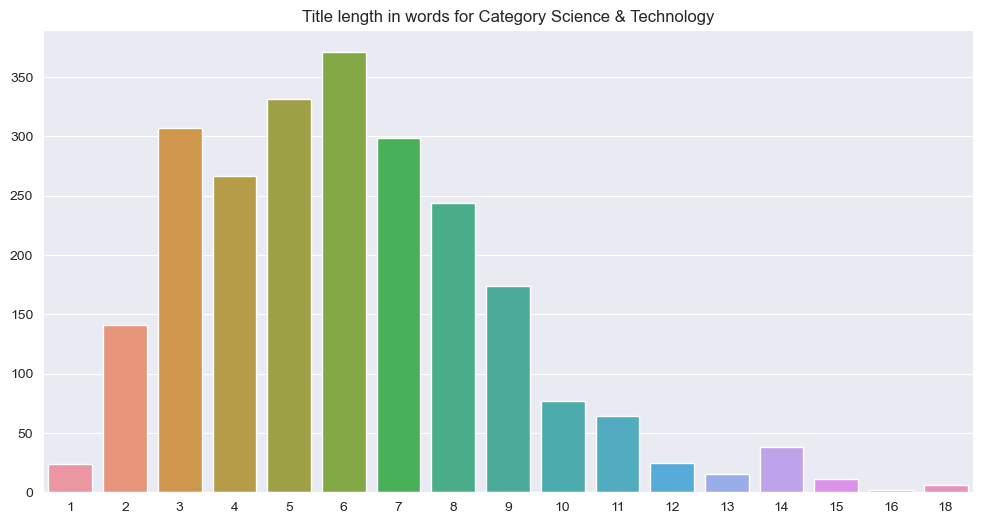

In [19]:
for category_name, category_id_filter in categories:
    filtered_df = df[df['category_id'] == category_id_filter]
    filtered_df.loc[:, 'Word_len'] = filtered_df['title'].apply(lambda x: len(x.split()))

    if filtered_df.empty:
        print(f"No titles found for Category {category_name}")
        continue

    word_len_counts = filtered_df['Word_len'].value_counts().reset_index()
    word_len_counts.columns = ['Word_len', 'N']

    plt.figure(figsize=(12, 6))
    sns.barplot(data=word_len_counts, x='Word_len', y='N')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f'Title length in words for Category {category_name}')
    plt.show()

In [20]:
def title_word_counts_with_colormap(df, category_name):
    df['category_name'] = category_name
    df = df[df['category_name'] == category_name]
    
    # Split the title string into words
    df['title_words'] = df['title'].str.split()
    
    # Remove punctuation marks from the title words
    df['title_words'] = df['title_words'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x])
    
    # Count the number of words in each title
    df['title_word_count'] = df['title_words'].apply(lambda x: len(x))
    
    # Plot a histogram of the title word counts
    n, bins, patches = plt.hist(df['title_word_count'], bins=100)
    cmap = cm.get_cmap('Blues')
    for i, patch in enumerate(patches):
        patch.set_fc(cmap(n[i]/max(n)))
        
    plt.xlabel('Title Word Count')
    plt.ylabel('Frequency')
    plt.title('Distribution of Title Word Counts for Category: ' + category_name)
    plt.show()
    
    #return df

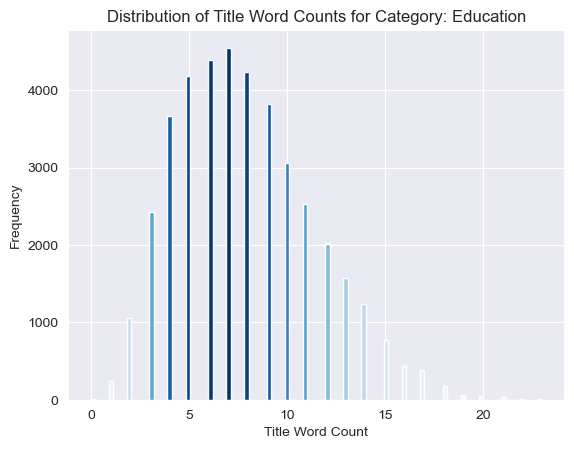

In [21]:
title_word_counts_with_colormap(df, "Education")

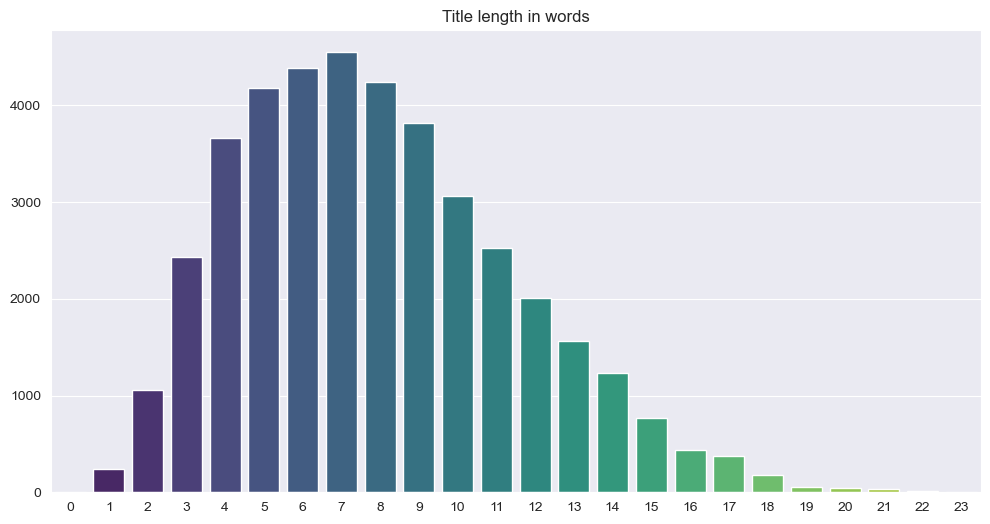

In [22]:
# Relationship between title length and likes

df['Word_len'] = df['title'].apply(lambda x: len(x.split()))

word_len_counts = df['Word_len'].value_counts().reset_index()
word_len_counts.columns = ['Word_len', 'N']

plt.figure(figsize=(12, 6))
sns.barplot(data=word_len_counts, x='Word_len', y='N', palette='viridis')
plt.xlabel(None)
plt.ylabel(None)
plt.title('Title length in words')
plt.show()

def visualize_title_length(df, category_name):
    df = df[df['category_name'] == category_name]
    #df['Word_len'] = df['title'].apply(lambda x: len(x.split()))
    # Split the title string into words
    df['Word_len'] = df['title'].str.split()
    # Remove punctuation marks from the title words
    df['Word_len'] = df['Word_len'].apply(lambda x: [word.translate(str.maketrans('', '', string.punctuation)) for word in x]) 
    # Count the number of words in each title
    df['Word_len'] = df['Word_len'].apply(lambda x: len(x))
    
    # Create a dataframe that contains the word length counts
    word_len_counts = df['Word_len'].value_counts().reset_index()
    word_len_counts.columns = ['Word_len', 'N']
    
    # Plot the title length distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(data=word_len_counts, x='Word_len', y='N', palette='viridis')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title('Title length in words for Category: ' + category_name)
    plt.show()
    
    return df

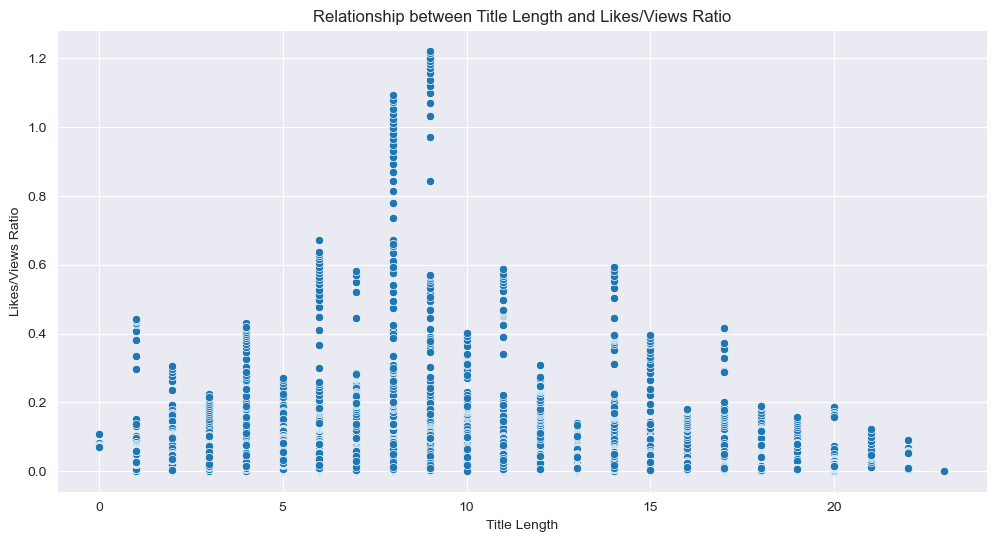

In [23]:
# Add a new column for the length of the title
df['title_length'] = df['title'].str.len()

# Calculate the likes/views ratio
df['likes_views_ratio'] = df['likes'] / df['views']

# Plot the scatter plot for the relationship between title length and likes/views ratio
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Word_len', y='likes_views_ratio', data=df)
plt.title("Relationship between Title Length and Likes/Views Ratio")
plt.xlabel("Title Length")
plt.ylabel("Likes/Views Ratio")

plt.show()

# Function for each category
def title_length_likes_views_ratio(df, category_name):
    df = df[df['category_name'] == category_name]
    # Plot the scatter plot for the relationship between title length and likes/views ratio
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='title_length', y='like_percentage', data=df)
    plt.title("Relationship between Title Length and Likes/Views Ratio for Category: " + category_name)
    plt.xlabel("Title Length")
    plt.ylabel("Likes/Views Ratio")

    plt.show()

### Emoji Analysis

In [24]:
!pip install emoji

In [25]:
import emoji

def contains_emoji(text):
    for character in text:
        if character in emoji.unicode_codes.EMOJI_DATA:
            return True
    return False

# Create a new column indicating if the title contains an emoji
df['title_has_emoji'] = df['title'].apply(contains_emoji)

# Example: Show rows where the title contains an emoji
df[df['title_has_emoji'] == True].head()

video_id trending_date                                       title  \
118   2VP846QcA_4    2017-11-14  Trained Become Batman 🦇 ( Justice League )   
391   2VP846QcA_4    2017-11-15  Trained Become Batman 🦇 ( Justice League )   
1622  bAfn2duIlN8    2017-11-22                 🎃 make Pumpkin Pie Mistakes   
1866  bAfn2duIlN8    2017-11-23                 🎃 make Pumpkin Pie Mistakes   
2069  bAfn2duIlN8    2017-11-24                 🎃 make Pumpkin Pie Mistakes   

       channel_title  category_id              publish_time  \
118   Michelle Khare           24 2017-11-09 11:30:00+00:00   
391   Michelle Khare           24 2017-11-09 11:30:00+00:00   
1622        iJustine           22 2017-11-21 19:39:43+00:00   
1866        iJustine           22 2017-11-21 19:39:43+00:00   
2069        iJustine           22 2017-11-21 19:39:43+00:00   

                                                   tags   views  likes  \
118   justice league| '' dc comics '' | '' michelle ...  139955   4417   
391   justice league| '' dc comics '' | '' michelle ...  155533   4621   
1622  ijustine| '' make pumpkin pie '' | '' pumpkin ...   76859   4895   
1866  ijustine| '' make pumpkin pie '' | '' pumpkin ...  126015   6562   
2069  ijustine| '' make pumpkin pie '' | '' pumpkin ...  142155   6971   

      dislikes  ...  video_error_or_removed  \
118        217  ...                   False   
391        233  ...                   False   
1622       164  ...                   False   
1866       253  ...                   False   
2069       268  ...                   False   

                                            description  category_name  \
118   honor upcoming Justice League ( 2017 ) film , ...      Education   
391   honor upcoming Justice League ( 2017 ) film , ...      Education   
1622  Making pumpkin pie .. least trying best.\n► SU...      Education   
1866  Making pumpkin pie .. least trying best.\n► SU...      Education   
2069  Making pumpkin pie .. least trying best.\n► SU...      Education   

            category  like_percentage like_dislike_ratio Word_len  \
118    Entertainment         3.156014          20.354839        8   
391    Entertainment         2.971074          19.832618        8   
1622  People & Blogs         6.368805          29.847561        5   
1866  People & Blogs         5.207317          25.936759        5   
2069  People & Blogs         4.903802          26.011194        5   

     title_length  likes_views_ratio  title_has_emoji  
118            42           0.031560             True  
391            42           0.029711             True  
1622           27           0.063688             True  
1866           27           0.052073             True  
2069           27           0.049038             True  

[5 rows x 24 columns]

                    likes         views
emoji_count                            
0            74404.953294  1.309449e+06
1            89700.042135  1.590665e+06
2            33362.490000  1.168289e+06
3            23162.681818  5.790974e+05
4             2623.333333  1.485203e+05


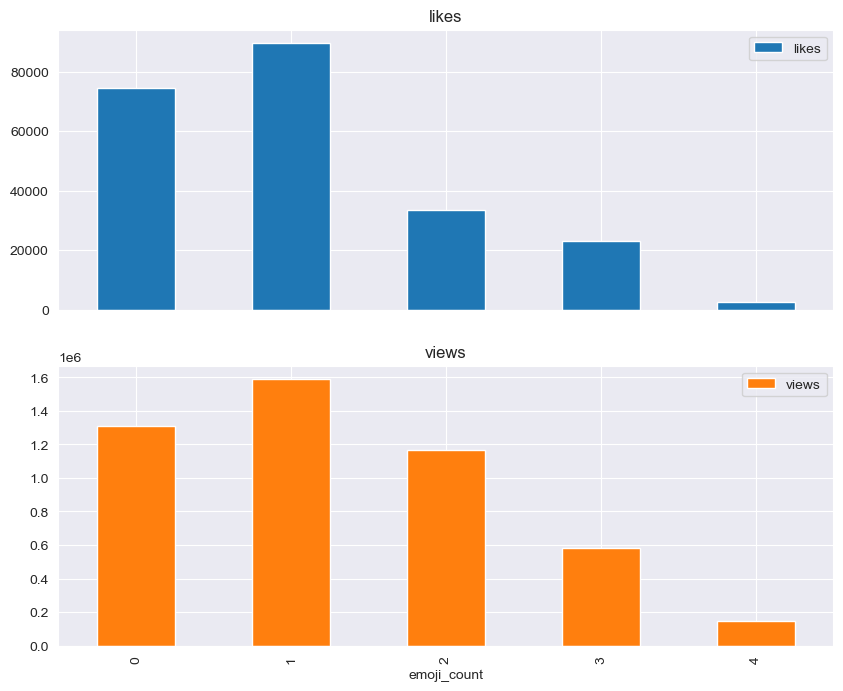

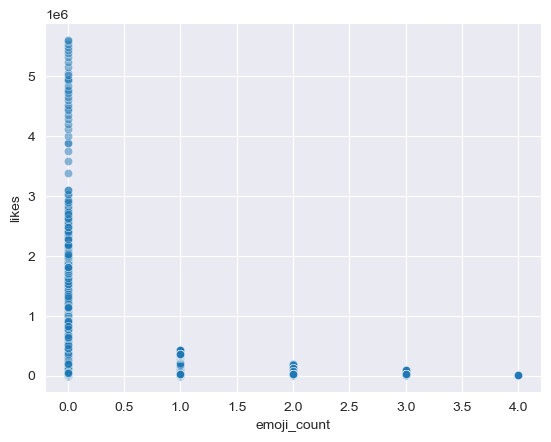

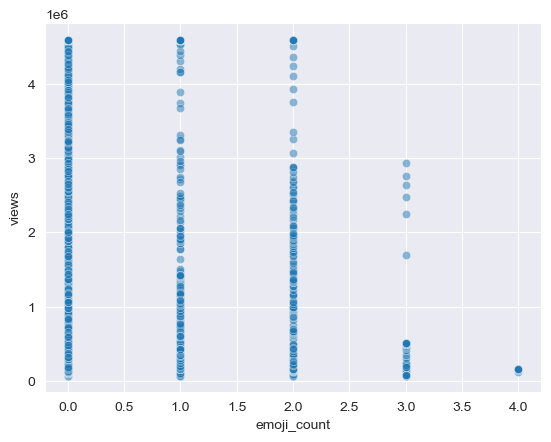

®    128
📦     53
🚔     52
❤     28
🎄     27
🍕     26
💍     24
✨     20
🏻     20
😂     19
dtype: int64


/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128660 (\N{ONCOMING POLICE CAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10084 (\N{HEAVY BLACK HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127829 (\N{SLICE OF PIZZA}) missing from current font.
  fig.canvas.print_figure(b

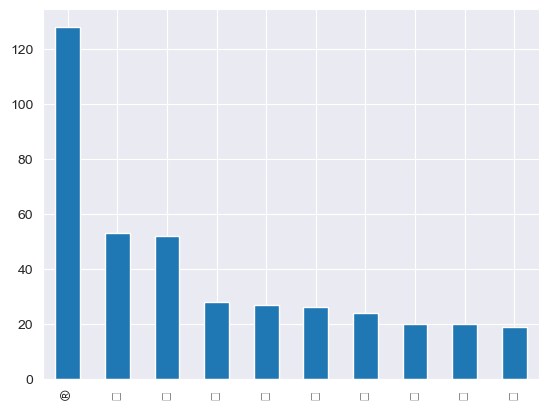

/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/151711075.py:47: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  mean_likes.append(filtered_df[filtered_df['title'].str.contains(emoji)].mean()['likes'])
/var/folders/vp/59mf90y14gb7brcxtzdd_00w0000gn/T/ipykernel_76265/151711075.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_likes.append(filtered_df[filtered_df['title'].str.contains(emoji)].mean()['likes'])


<Figure size 1000x500 with 0 Axes>

/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128660 (\N{ONCOMING POLICE CAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10084 (\N{HEAVY BLACK HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/helen/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127829 (\N{SLICE OF PIZZA}) missing from current font.
  fig.canvas.print_figure(b

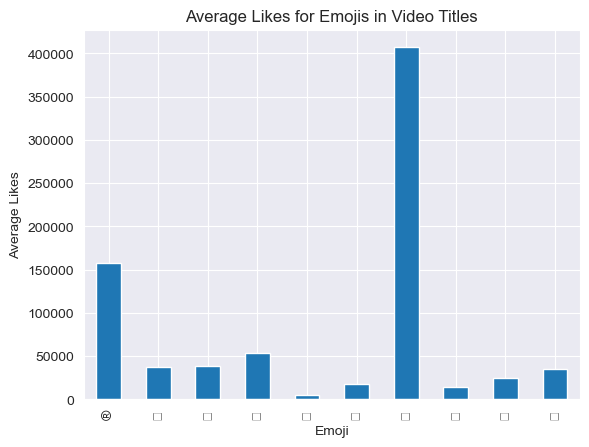

In [26]:
# Function to count emojis in a text
def count_emojis(text):
    return sum(char in emoji.unicode_codes.EMOJI_DATA for char in text)

# Add emoji_count column
df['emoji_count'] = df['title'].apply(count_emojis)

# Analysis 2: Average likes and views for different numbers of emojis in the title
grouped_by_emoji_count = df.groupby('emoji_count').mean()[['likes', 'views']]
print(grouped_by_emoji_count)

# Visualize the results
grouped_by_emoji_count.plot(kind='bar', subplots=True, layout=(2, 1), figsize=(10, 8))
plt.show()

# Analysis 3: Scatter plot of number of emojis in the title and likes/views
sns.scatterplot(x='emoji_count', y='likes', data=df, alpha=0.5)
plt.show()

sns.scatterplot(x='emoji_count', y='views', data=df, alpha=0.5)
plt.show()

# Analysis 4: Most common emojis in the titles
all_emojis = [char for title in df['title'] for char in title if char in emoji.unicode_codes.EMOJI_DATA]
emoji_counts = pd.Series(all_emojis).value_counts().head(10)
print(emoji_counts)

emoji_counts.plot(kind='bar')
plt.show()

# Analysis 5: Average likes and views for videos with specific emojis in the title
def has_emoji(text, emj):
    return emj in text

# Choose emojis of interest
emojis_of_interest = emoji_counts.index.tolist()

# Add columns for each emoji of interest
for emj in emojis_of_interest:
    df[f'has_{emj}'] = df['title'].apply(lambda text: has_emoji(text, emj))

# Calculate average likes and views for each emoji
mean_likes = []
filtered_df = df[df['title'].apply(lambda title: any(emoji in title for emoji in emojis_of_interest))]

for emoji in emojis_of_interest:
    mean_likes.append(filtered_df[filtered_df['title'].str.contains(emoji)].mean()['likes'])

emoji_likes_views_df = pd.DataFrame({'Emoji': emojis_of_interest, 'Average Likes': mean_likes})

plt.figure(figsize=(10, 5))
ax = emoji_likes_views_df.plot.bar(x='Emoji', y='Average Likes', legend=False)
plt.xlabel('Emoji')
plt.ylabel('Average Likes')
plt.title('Average Likes for Emojis in Video Titles')

# Display emoji characters on the x-axis
ax.set_xticklabels(emoji_likes_views_df['Emoji'])

plt.show()

In [27]:
import re

emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
"]+", flags=re.UNICODE)

emoji_counter = {}

for title in df['title']:
    emojis_found = emoji_pattern.findall(title)
    for emoji in emojis_found:
        if emoji not in emoji_counter:
            emoji_counter[emoji] = 1
        else:
            emoji_counter[emoji] += 1
print(emoji_counter)

# Prepare a string containing all the emoji characters
emoji_string = ''.join([emoji * count for emoji, count in emoji_counter.items()])
# Sort the dictionary by values in descending order
sorted_emojis = sorted(emoji_counter.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 emojis
top_10_emojis = dict(sorted_emojis[:10])

# Print the top 10 emojis with their counts
for emoji, count in top_10_emojis.items():
    print(f"{emoji}: {count}")

{'🎃': 8, '👶🏼': 7, '😉🎄': 3, '👀💕': 5, '👊🏼': 4, '😱': 4, '🔥': 11, '🎄': 24, '🎅🏻': 7, '💇': 7, '💰': 4, '🏼': 6, '💥': 6, '🍾': 6, '🇰🇵': 4, '🍎🍌🍍': 5, '🇺🇸': 3, '🎓': 2, '💩💩': 1, '💛🌼': 5, '💔😔': 6, '🙄🙄🙄': 6, '🌹🏁': 4, '💕😍': 2, '🔪': 2, '😂': 19, '💖': 3, '🇭🇰': 2, '🍫': 7, '💋': 16, '🚗': 6, '🔴': 4, '💚💜': 10, '💘': 8, '🌮🍕': 8, '🍎': 3, '🐕': 16, '🎤': 11, '🍔': 12, '🍟': 16, '🌈🌻': 11, '😉': 3, '📦🚔': 52, '🙅🏻': 13, '🙈': 14, '🗑': 12, '🍒': 16, '🍕': 18, '💍': 24, '🍣': 7, '🍩': 7, '📦': 1, '🍉': 2, '💧': 1}
📦🚔: 52
🎄: 24
💍: 24
😂: 19
🍕: 18
💋: 16
🐕: 16
🍟: 16
🍒: 16
🙈: 14


### Publish Time & Metrics Relationship

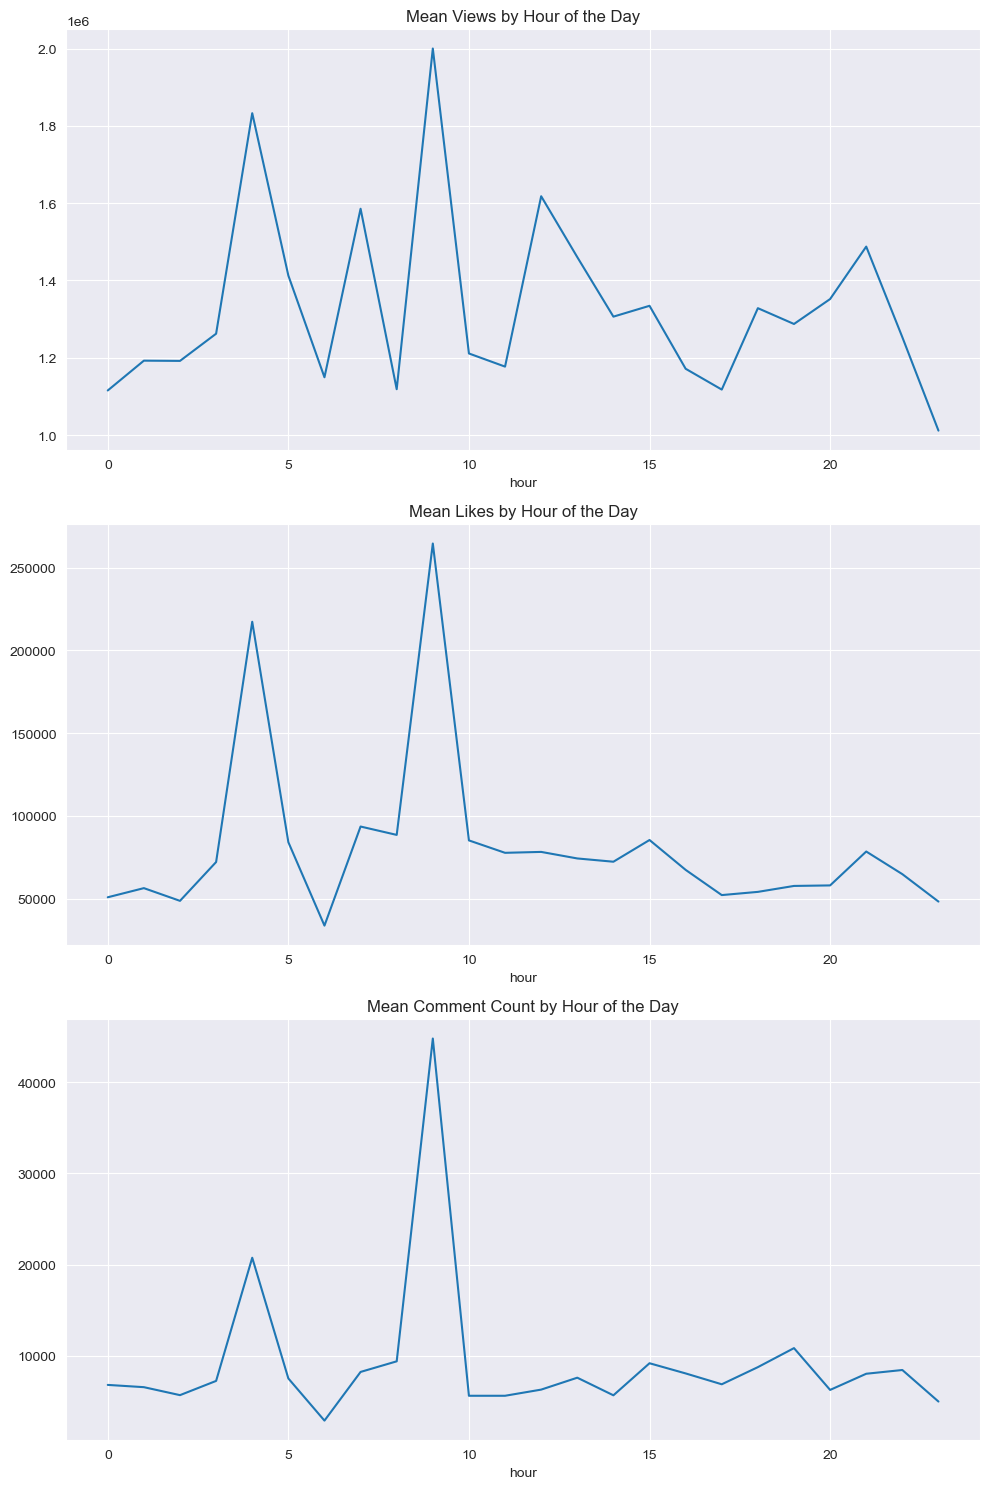

In [28]:
#### Explore relationship between publish_time and  views, likes, and comment_counts

# Convert the publish_time column to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Extract the hour of the day from the publish_time column
df['hour'] = df['publish_time'].dt.hour

# Group the DataFrame by hour of the day and calculate the mean views, likes, and comment counts for each group
grouped = df.groupby(['hour']).mean()[['views', 'likes', 'comment_count']]

# Plot the mean views, likes, and comment counts over the hour of the day
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

grouped['views'].plot(ax=ax[0], title='Mean Views by Hour of the Day')
grouped['likes'].plot(ax=ax[1], title='Mean Likes by Hour of the Day')
grouped['comment_count'].plot(ax=ax[2], title='Mean Comment Count by Hour of the Day')

plt.tight_layout()
plt.show()

In [29]:
# Calculate the total views, likes, and comment counts for each hour of the day
totals = df.groupby(['hour']).sum()[['views', 'likes', 'comment_count']]

# Sort the results in descending order
top_hours = totals.sort_values(by=['views', 'likes', 'comment_count'], ascending=False)

print("Top Hours for Views:")
print(top_hours['views'].head())

print("\nTop Hours for Likes:")
print(top_hours['likes'].head())

print("\nTop Hours for Comment Counts:")
print(top_hours['comment_count'].head())

Top Hours for Views:
hour
15    4641029739
16    4292452323
17    3851393934
18    3832032058
14    3664358134
Name: views, dtype: int64

Top Hours for Likes:
hour
15    297313476
16    247123472
17    179940384
18    156230056
14    202990874
Name: likes, dtype: int64

Top Hours for Comment Counts:
hour
15    31983705
16    29605755
17    23743905
18    25298667
14    15938930
Name: comment_count, dtype: int64


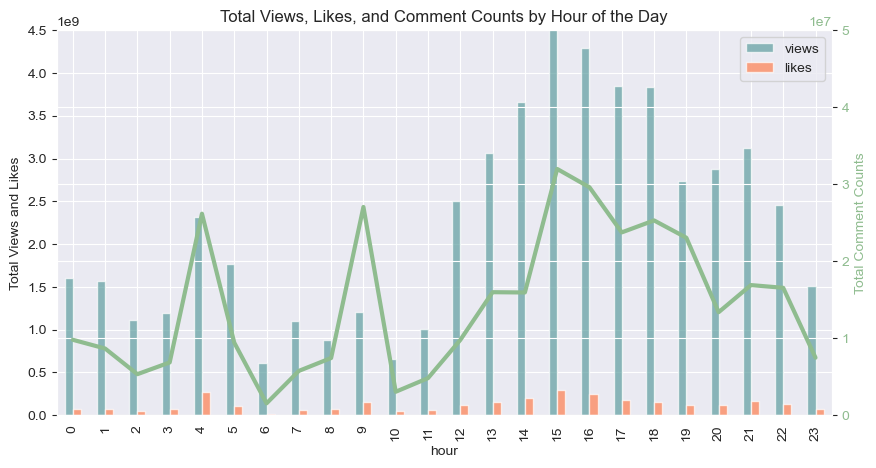

In [30]:
# Create a bar plot with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot the total views and likes on the first y-axis
totals[['views', 'likes']].plot(kind='bar', ax=ax1, color=['#5f9ea0', '#ff7f50'], alpha=0.7)

# Set the y-axis label and limits for views and likes
ax1.set_ylabel('Total Views and Likes')
ax1.set_ylim([0, 4.5e9])

# Plot the comment counts on the second y-axis
totals['comment_count'].plot(kind='line', ax=ax2, color='#8fbc8f', linewidth=3)

# Set the y-axis label and limits for comment counts
ax2.set_ylabel('Total Comment Counts', color='#8fbc8f')
ax2.tick_params(axis='y', labelcolor='#8fbc8f')
ax2.set_ylim([0, 5e7])

# Set the x-axis label and tick labels
plt.xlabel('Hour of the Day')
plt.xticks(range(24), range(24))

# Set the title of the plot
plt.title('Total Views, Likes, and Comment Counts by Hour of the Day')

plt.show()

                   views         likes  comment_count
time_block                                           
Morning     1.372871e+06  93812.685417    9293.482051
Afternoon   1.311736e+06  75538.682212    8559.329874
Night       1.295407e+06  62241.496738    7884.797859


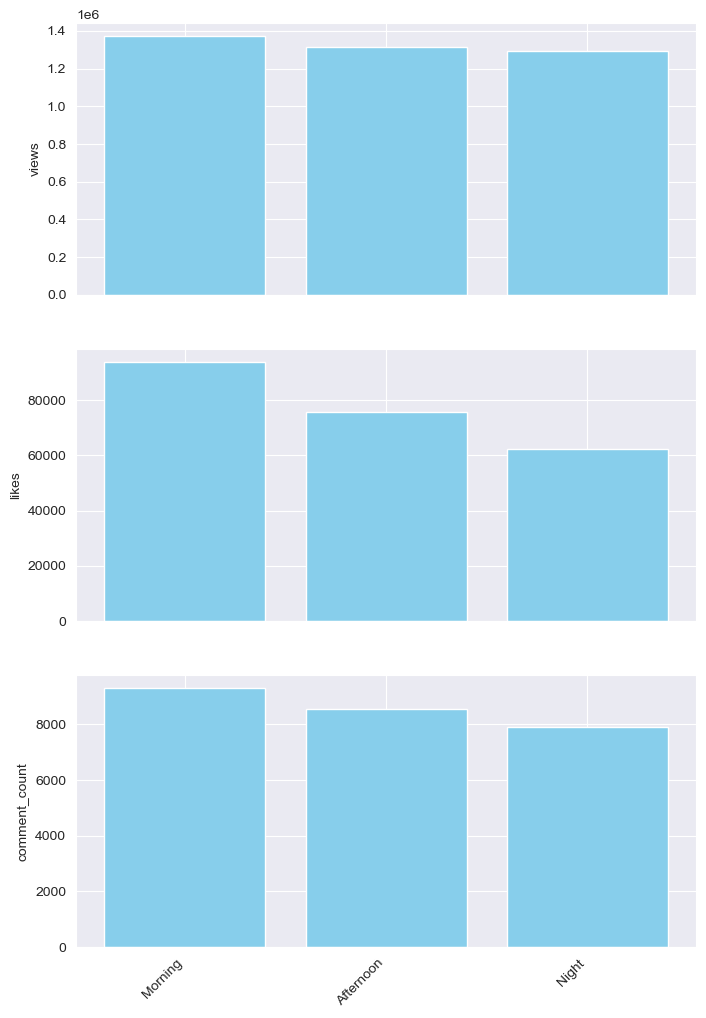

In [31]:
# Convert the publish_time column to datetime
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

# Create a new column indicating which time block each video belongs to
time_blocks = ['Morning', 'Afternoon', 'Night']
bins = [0, 6, 18, 24]
df['time_block'] = pd.cut(df['publish_time'].dt.hour, bins=bins, labels=time_blocks)

# Calculate the mean views, likes, and comment counts for each time block
means = df.groupby(['time_block']).mean()[['views', 'likes', 'comment_count']]

# Print the mean values for each time block
print(means)

# Plot the mean views, likes, and comment counts for each time block
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
for i, col in enumerate(['views', 'likes', 'comment_count']):
    axs[i].bar(means.index, means[col], color='skyblue')
    axs[i].set_ylabel(col)
    axs[i].set_ylim(bottom=0)
plt.xticks(rotation=45, ha='right')
plt.show()

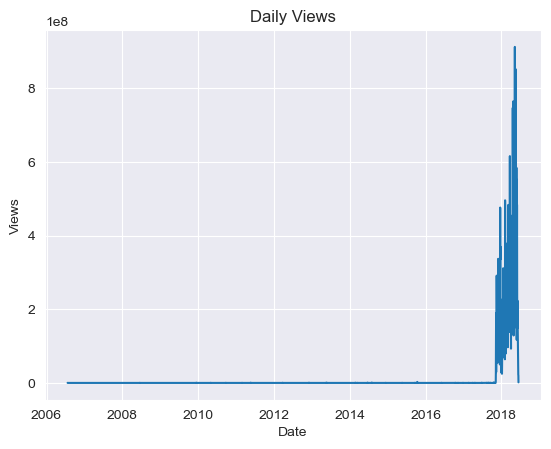

In [32]:
# Convert data types
df['views'] = df['views'].astype(int)
df['likes'] = df['likes'].astype(int)
df['dislikes'] = df['dislikes'].astype(int)
df['comment_count'] = df['comment_count'].astype(int)

# Resample to daily frequency
daily_df = df.resample('D', on='publish_time').sum()

# Visualize daily views
plt.plot(daily_df['views'])
plt.xlabel('Date')
plt.ylabel('Views')
plt.title('Daily Views')
plt.show()

### Time Series Analysis & Forecasting

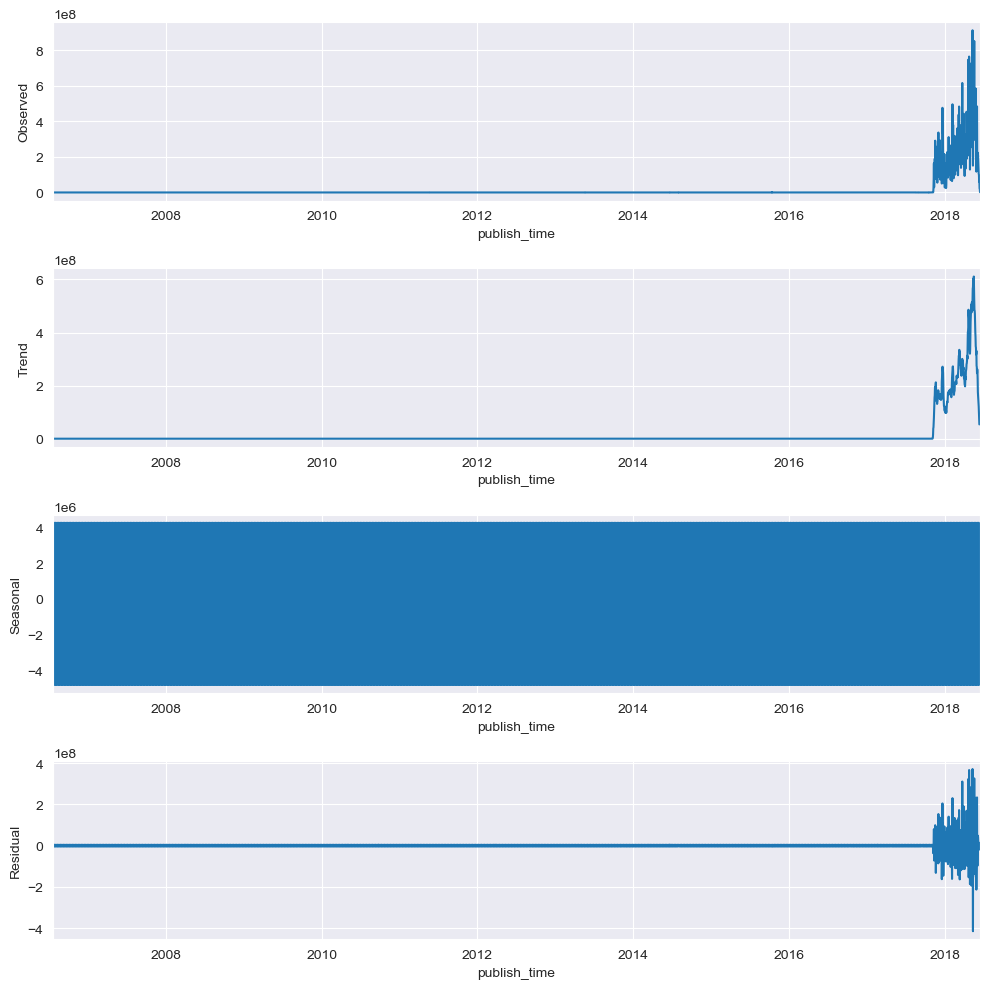

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomp = seasonal_decompose(daily_df['views'], model='additive')

# Plot decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,10))
decomp.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomp.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomp.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomp.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

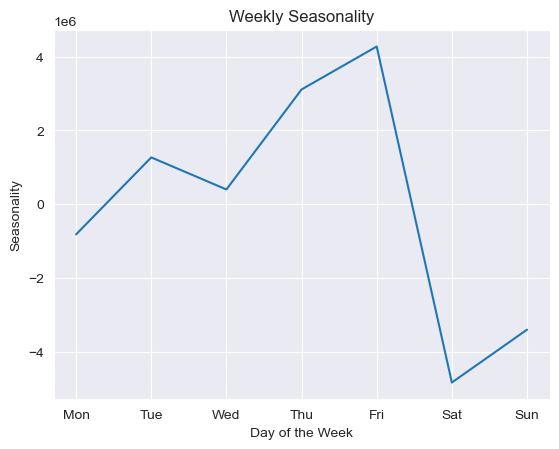

In [34]:
# Identify weekly seasonality
seasonal_df = pd.DataFrame(decomp.seasonal)
seasonal_df['dayofweek'] = seasonal_df.index.dayofweek
weekly_grouped = seasonal_df.groupby('dayofweek').mean()

# Visualize weekly seasonality
plt.plot(weekly_grouped)
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the Week')
plt.ylabel('Seasonality')
plt.title('Weekly Seasonality')
plt.show()

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create time series model
model = SARIMAX(daily_df['views'], order=(2,1,2), seasonal_order=(1,1,1,7))
results = model.fit()

# Print model summary
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85677D+01    |proj g|=  9.86351D-02

At iterate    5    f=  1.85125D+01    |proj g|=  1.81168D-02

At iterate   10    f=  1.85106D+01    |proj g|=  8.90232D-04

At iterate   15    f=  1.85099D+01    |proj g|=  1.51467D-02

At iterate   20    f=  1.85079D+01    |proj g|=  2.71795D-02

At iterate   25    f=  1.85051D+01    |proj g|=  7.53380D-04

At iterate   30    f=  1.85050D+01    |proj g|=  4.64631D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [36]:
!pip install pmdarima

In [37]:
import pmdarima as pm

# Loop through the categories
for category_name, category_id in categories:

    # Select data for the current category
    category_df = df[df['category_id'] == category_id]

    # Convert daily data to weekly data
    daily_df = df.resample('D', on='publish_time').sum()

    # Predict views for next week
    start_date = daily_df.index[-1] + pd.Timedelta(days=1)
    end_date = start_date + pd.Timedelta(days=6)
    next_week = pd.date_range(start=start_date, end=end_date, freq='D')
    next_week_preds = results.predict(start=start_date, end=end_date)

    # Calculate predicted views, likes, and comment counts for each day and time
    dayofweek = next_week.dayofweek
    hour = np.arange(0,24)
    time_blocks = ['Morning', 'Afternoon', 'Night']
    views_preds = pd.DataFrame(index=hour, columns=dayofweek)
    likes_preds = pd.DataFrame(index=hour, columns=dayofweek)
    comments_preds = pd.DataFrame(index=hour, columns=dayofweek)

    for i in range(7):
        for j in range(24):
            if i*24+j < len(next_week_preds):
                views_preds.iloc[j,i] = next_week_preds[i*24+j]
            likes_preds.iloc[j,i] = daily_df['likes'].mean()
            comments_preds.iloc[j,i] = daily_df['comment_count'].mean()

    # Aggregate predictions by time block
    morning_hours = range(6,12)
    afternoon_hours = range(12,18)
    night_hours = list(range(18,24)) + list(range(0,6))

    views_morning = views_preds.loc[morning_hours,:].mean().mean()
    views_afternoon = views_preds.loc[afternoon_hours,:].mean().mean()
    views_night = views_preds.loc[night_hours,:].mean().mean()

    likes_morning = likes_preds.loc[morning_hours,:].mean().mean()
    likes_afternoon = likes_preds.loc[afternoon_hours,:].mean().mean()
    likes_night = likes_preds.loc[night_hours,:].mean().mean()

    comments_morning = comments_preds.loc[morning_hours,:].mean().mean()
    comments_afternoon = comments_preds.loc[afternoon_hours,:].mean().mean()
    comments_night = comments_preds.loc[night_hours,:].mean().mean()


    # Find best hour to post for views
    best_views_hour = hour[np.argmax([views_preds.loc[morning_hours,:].mean().mean(),
                                  views_preds.loc[afternoon_hours,:].mean().mean(),
                                  views_preds.loc[night_hours,:].mean().mean()])]
    # Find best hour to post for likes
    best_likes_hour = hour[np.argmax([likes_preds.loc[morning_hours,:].mean().mean(),
                                  likes_preds.loc[afternoon_hours,:].mean().mean(),
                                  likes_preds.loc[night_hours,:].mean().mean()])]
    # Find best hour to post for comments
    best_comments_hour = hour[np.argmax([comments_preds.loc[morning_hours,:].mean().mean(),
                                     comments_preds.loc[afternoon_hours,:].mean().mean(),
                                     comments_preds.loc[night_hours,:].mean().mean()])]
    
    # Print recommendations
    print(f"Recommendations for {category_name}:")
    print(f"Best time and hour to post for views: {time_blocks[np.argmax([views_morning, views_afternoon, views_night])]}, {best_views_hour}")
    print(f"Best time and hour to post for likes: {time_blocks[np.argmax([likes_morning, likes_afternoon, likes_night])]}, {best_likes_hour}")
    print(f"Best time and hour to post for comments: {time_blocks[np.argmax([comments_morning, comments_afternoon, comments_night])]}, {best_comments_hour}")

Recommendations for News & Politics:
Best time and hour to post for views: Afternoon, 1
Best time and hour to post for likes: Morning, 0
Best time and hour to post for comments: Morning, 0
Recommendations for Music:
Best time and hour to post for views: Afternoon, 1
Best time and hour to post for likes: Morning, 0
Best time and hour to post for comments: Morning, 0
Recommendations for Education:
Best time and hour to post for views: Afternoon, 1
Best time and hour to post for likes: Morning, 0
Best time and hour to post for comments: Morning, 0
Recommendations for How-to & Style:
Best time and hour to post for views: Afternoon, 1
Best time and hour to post for likes: Morning, 0
Best time and hour to post for comments: Morning, 0
Recommendations for Sports:
Best time and hour to post for views: Afternoon, 1
Best time and hour to post for likes: Morning, 0
Best time and hour to post for comments: Morning, 0
Recommendations for Entertainment:
Best time and hour to post for views: Afternoo

## Sentiment Analysis

In [38]:
# Sentiment analysis of title & description
def sentiment_analysis(df):
  # Sentiment analysis of column 'title'
  df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
  # Sentiment analysis of column 'description'
  df['description_sentiment'] = df['description'].apply(lambda x: TextBlob(x).sentiment.polarity)

sentiment_analysis(df)
#df

Index(['Autos & Vehicles', 'Comedy', 'Education', 'Entertainment',
       'Film & Animation', 'Gaming', 'Howto & Style', 'Music',
       'News & Politics', 'Nonprofits & Activism', 'People & Blogs',
       'Pets & Animals', 'Science & Technology', 'Shows', 'Sports',
       'Travel and Events'],
      dtype='object', name='category') [ 0.13025596  0.06384678 -0.02710245  0.08975897  0.09588152  0.07676913
  0.0930027   0.14810507  0.03291429  0.17779484  0.14493432  0.14258626
  0.09767781 -0.23964912  0.13152203  0.19233967]


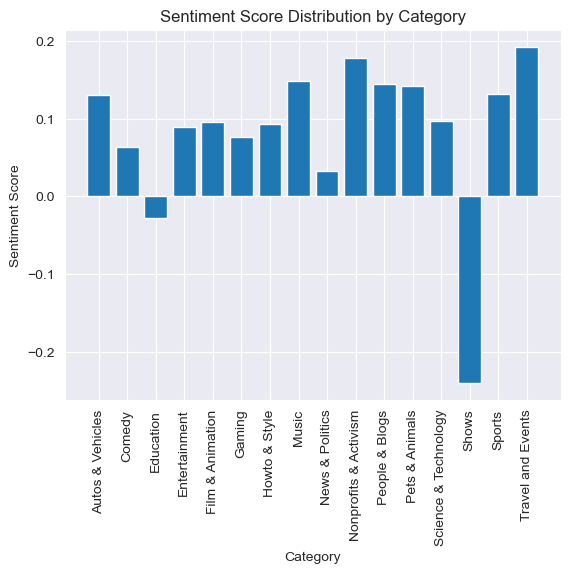

In [39]:
# Show sentiment score of each categories instead of individual videos
def category_sentiment(df):
  # Calculate the sentiment score of the title for each category
  category_sentiments = df.groupby('category')['title'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

  fig, ax = plt.subplots()
  ax.bar(category_sentiments.index, category_sentiments.values)
  ax.set_title("Sentiment Score Distribution by Category")
  ax.set_xlabel("Category")
  ax.set_ylabel("Sentiment Score")
  ax.tick_params(axis='x', rotation=90)
  print(category_sentiments.index, category_sentiments.values)

category_sentiment(df)

In [40]:
# show top five titles of each category with the highest and lowest sentiment score
df = df[ df['category'].isin(['Shows', 'Education']) ]
df

df['title_sentiment'] = df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sorted = df.sort_values('title_sentiment', ascending=True)

# Group the sorted DataFrame by category
grouped = df_sorted.groupby('category')

# Retrieve the top 5 titles with highest sentiment scores and lowest sentiment scores in each category
top_5_low_sentiments = grouped.tail(5)[['title','category','title_sentiment']].drop_duplicates() 

# Filter the DataFrame to include only 'Shows' and 'Education' categories
top_5_low_sentiments = top_5_low_sentiments[top_5_low_sentiments['category'].isin(['Shows', 'Education'])]

top_5_low_sentiments

title   category  \
14502  Apple HomePod : Everything know buy ( Apple By...      Shows   
18822                          Country Best Technology ?  Education   
8585        HAIR COLOR BEST SUIT SKIN TONE ! | bradmondo  Education   

       title_sentiment  
14502              0.0  
18822              1.0  
8585               1.0